# Project Introduction: Integrating Stochastic Oscillator and Average True Range (ATR) for Stock Analysis

## Objective
The objective of this project is to develop a reliable stock screening tool that identifies potential buy and sell signals using two powerful technical indicators: the Stochastic Oscillator and the Average True Range (ATR). By combining these indicators, we aim to enhance the accuracy of our signals, leveraging the strengths of both momentum and volatility analysis.

## Background
Technical analysis involves using historical price and volume data to forecast future price movements. Among the myriad of technical indicators available, the Stochastic Oscillator and ATR are two widely respected tools that traders use to assess market conditions.

## Why Stochastic Oscillator and ATR?
### Stochastic Oscillator
- **Purpose**: The Stochastic Oscillator is used to measure the momentum of price movements and identify potential overbought or oversold conditions.
- **Components**:
  - **%K Line**: The main line, typically calculated over a 14-period interval.
  - **%D Line**: The signal line, which is a 3-period moving average of the %K line.
- **Signals**:
  - **Overbought Condition**: %K and %D lines above 80, indicating potential for a price reversal to the downside.
  - **Oversold Condition**: %K and %D lines below 20, indicating potential for a price reversal to the upside.
  - **Buy Signal**: %K line crosses above the %D line in the oversold region.
  - **Sell Signal**: %K line crosses below the %D line in the overbought region.

### Average True Range (ATR)
- **Purpose**: The ATR is used to measure market volatility by examining the range of price movements over a given period.
- **Components**:
  - **True Range (TR)**: The greatest of the following:
    - Current high minus the current low
    - Absolute value of the current high minus the previous close
    - Absolute value of the current low minus the previous close
  - **ATR Line**: A moving average of the True Range, typically calculated over a 14-period interval.
- **Signals**:
  - **High Volatility**: ATR above a certain threshold, indicating significant price movements.
  - **Low Volatility**: ATR below a certain threshold, indicating minimal price movements.

## Combining Stochastic Oscillator and ATR
Using these indicators together can help confirm signals and reduce false positives:
- **Enhanced Accuracy**: While the Stochastic Oscillator helps identify momentum and potential reversals, ATR provides insight into market volatility, filtering out weak signals in low volatility environments.
- **Filter for False Signals**: The Stochastic Oscillator can sometimes give premature signals in volatile markets. By requiring confirmation through ATR's volatility measure, we filter out some of these false signals, increasing the likelihood that our signals are accurate.

## Methodology

- **Data Collection:** We collect historical price data for a selection of stocks over a specified period.
- **Indicator Calculation:** We calculate the Stochastic Oscillator and ATR for each stock.
- **Stock Screening:** We screen stocks based on the following criteria:
  - **Buy Criteria:** Stochastic Oscillator indicates an oversold condition and a cross of %K above %D, with ATR indicating a high volatility environment.
  - **Sell Criteria:** Stochastic Oscillator indicates an overbought condition and a cross of %K below %D, with ATR indicating a high volatility environment.
- **Visualization and Export:** We visualize the results and export the screened stocks to a CSV file for further analysis.

## Data Source and Flexibility

In this analysis, we will be using data from the FTSE 250 companies. However, feel free to use any dataset you prefer by simply changing the CSV file name in the script. Ensure that your dataset contains a column named "Ticker".

## Conclusion

This project aims to leverage the complementary strengths of the Stochastic Oscillator and ATR to create an intriguing stock screening tool. By considering both momentum and market volatility, our signals offer interesting insights designed to inspire further analysis. The chosen thresholds and periods are standard and widely accepted in technical analysis, providing a thought-provoking starting point for potential future exploration.



In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import contextlib
import sys
import logging 
import contextlib
import sys
import os
from tqdm import tqdm

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


# Function to calculate Average True Range (ATR)
def calculate_atr(data, window=14):
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift(1))
    data['True Range'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['True Range'].rolling(window=window).mean()
    return data

# Function to calculate Stochastic Oscillator
def calculate_stochastic_oscillator(data, window=14):
    data['Low_Min'] = data['Low'].rolling(window=window).min()
    data['High_Max'] = data['High'].rolling(window=window).max()
    data['Stochastic %K'] = 100 * ((data['Close'] - data['Low_Min']) / (data['High_Max'] - data['Low_Min']))
    data['Stochastic %D'] = data['Stochastic %K'].rolling(window=3).mean()
    return data

# Define threshold parameters
atr_threshold = 1.2  # Multiplier for mean ATR to determine high volatility
stochastic_overbought = 70  # Threshold for Stochastic %K and %D to determine overbought condition
stochastic_oversold = 30  # Threshold for Stochastic %K and %D to determine oversold condition

# Function to analyze stock for ATR and Stochastic Oscillator
def analyze_stock(symbol):
    try:
        # Fetch historical price data for the last 7 months
        end_date = datetime.now() - timedelta(days=1)
        start_date = end_date - timedelta(days=9*30)  # Approx. 7 months

        # Suppress yfinance output
        with suppress_output():
            data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        

                
        #data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        if data.empty:
            print(f"No data fetched for {symbol}")
            return None

        # Calculate ATR and Stochastic Oscillator
        data = calculate_atr(data)
        data = calculate_stochastic_oscillator(data)

        data.dropna(subset=['ATR', 'Stochastic %K', 'Stochastic %D'], inplace=True)

        if data.empty:
            print(f"Insufficient data after calculating indicators for {symbol}")
            return None

        # Calculate whether the stock meets the high volatility criteria
        latest_atr = data['ATR'].iloc[-1]
        mean_atr = data['ATR'].mean()
        is_high_volatility = latest_atr > atr_threshold * mean_atr

        # Calculate whether the stock meets the overbought/oversold criteria
        latest_stochastic_k = data['Stochastic %K'].iloc[-1]
        latest_stochastic_d = data['Stochastic %D'].iloc[-1]
        is_overbought = latest_stochastic_k > stochastic_overbought and latest_stochastic_d > stochastic_overbought
        is_oversold = latest_stochastic_k < stochastic_oversold and latest_stochastic_d < stochastic_oversold

        # Determine if the stock meets at least two of the criteria
        criteria_met = sum([is_high_volatility, is_overbought, is_oversold])
        meets_criteria = criteria_met >= 2

        return {
            "Symbol": symbol,
            "Data": data,
            "ATR": latest_atr,
            "Stochastic %K": latest_stochastic_k,
            "Stochastic %D": latest_stochastic_d,
            "High Volatility": is_high_volatility,
            "Overbought": is_overbought,
            "Oversold": is_oversold,
            "Meets Criteria": meets_criteria  # Only true if at least two criteria are met
        }

    except Exception as e:
        print(f"Error analyzing stock {symbol}: {e}")
        return None




# Load tickers from the CSV file
tickers_df = pd.read_csv('ftse_250_tickers.csv')
symbols = tickers_df['Ticker'].tolist()

# Initialize list to store results
results = []

# Analyze each stock
for symbol in tqdm(symbols, desc="Processing stocks"):
    stock_data = analyze_stock(symbol)
    if stock_data is not None and stock_data["Meets Criteria"]:  # Only include stocks meeting the criteria
        results.append(stock_data)

# Convert results to DataFrame
results_df = pd.DataFrame([{
    "Symbol": r["Symbol"],
    "ATR": r["ATR"],
    "Stochastic %K": r["Stochastic %K"],
    "Stochastic %D": r["Stochastic %D"],
    "High Volatility": r["High Volatility"],
    "Overbought": r["Overbought"],
    "Oversold": r["Oversold"],
    "Meets Criteria": r["Meets Criteria"]
} for r in results])

# Export results to CSV
results_df.to_csv("atr_stochastic_results.csv", index=False)

# Print results
results_df




Processing stocks: 100%|█████████████████████████████████████████████████████████████| 247/247 [00:26<00:00,  9.43it/s]


Symbol         ATR  Stochastic %K  Stochastic %D  High Volatility  \
0    MCG.L    2.873143      91.197180      86.122375             True   
1   MOON.L   10.200214     100.000000      93.307840             True   
2    QLT.L    4.335714      87.804881      74.476653             True   
3    GAW.L  372.657157      71.942446      79.136691             True   
4   BAKK.L    5.918215      70.454545      85.550628             True   
5    ITV.L    2.593714      80.645201      82.078872             True   
6    BWY.L   94.142857      91.911765      78.431373             True   
7    HOC.L    7.717860      77.372269      77.128964             True   
8   CURY.L    2.955215      93.370101      91.831006             True   
9    KLR.L   40.277998      98.237109      95.285603             True   
10   CTY.L    6.826787      73.469388      85.714286             True   
11   HSX.L   44.162362      84.455959      86.873921             True   
12   SRP.L    4.851428      83.333315      85.103766             True   
13  TMPL.L    4.336642      87.500000      89.583333             True   
14   JTC.L   35.011928      93.877551      94.666501             True   
15  LWDB.L   16.352068      83.598040      87.621701             True   
16   CKN.L  127.500000      87.628866      81.786942             True   
17  THRG.L   12.376426      98.046875      99.348958             True   
18   ASL.L   22.319981      85.767098      92.478458             True   
19   DLG.L   10.336430      15.107909      15.707430             True   
20   RDW.L   26.911216      83.443709      80.794702             True   
21   EOT.L   13.195857      81.395349      91.472868             True   
22   VTY.L   41.994219      81.446037      81.982866             True   
23  IBST.L    6.643573      99.083809      99.377147             True   
24  INDV.L   85.757215      18.922853      20.014556             True   
25   TPK.L   28.464286      93.690852      92.760200             True   
26   KIE.L    5.847499     100.000000      95.072748             True   
27  MGAM.L   12.539285      93.258427      91.502809             True   
28   BAB.L   18.469073      87.341772      71.334949             True   

    Overbought  Oversold  Meets Criteria  
0         True     False            True  
1         True     False            True  
2         True     False            True  
3         True     False            True  
4         True     False            True  
5         True     False            True  
6         True     False            True  
7         True     False            True  
8         True     False            True  
9         True     False            True  
10        True     False            True  
11        True     False            True  
12        True     False            True  
13        True     False            True  
14        True     False            True  
15        True     False            True  
16        True     False            True  
17        True     False            True  
18        True     False            True  
19       False      True            True  
20        True     False            True  
21        True     False            True  
22        True     False            True  
23        True     False            True  
24       False      True            True  
25        True     False            True  
26        True     False            True  
27        True     False            True  
28        True     False            True

In [3]:
# Calculate and print the detailed results
total_tickers = len(tickers_df)
tickers_meeting_criteria = len(results_df)
percentage_meeting_criteria = (tickers_meeting_criteria / total_tickers) * 100

# Print results
print("My preference is a 5-20% threshold which strikes a balance, ensuring a\nfocused yet diverse selection of stocks to allow further investigations.")
print(f"Tickers meeting criteria: {tickers_meeting_criteria}")
print(f"Percentage of shares that pass the criteria: {percentage_meeting_criteria:.2f}%")

# Determine if the percentage is within the desired filter range
if 5 <= percentage_meeting_criteria <= 20:
    print("The percentage of shares meeting the criteria is within the desirable range (5-20%).")
else:
    print("The percentage of shares meeting the criteria is outside the desirable range (5-15%).")

My preference is a 5-20% threshold which strikes a balance, ensuring a
focused yet diverse selection of stocks to allow further investigations.
Tickers meeting criteria: 29
Percentage of shares that pass the criteria: 11.74%
The percentage of shares meeting the criteria is within the desirable range (5-20%).


The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.



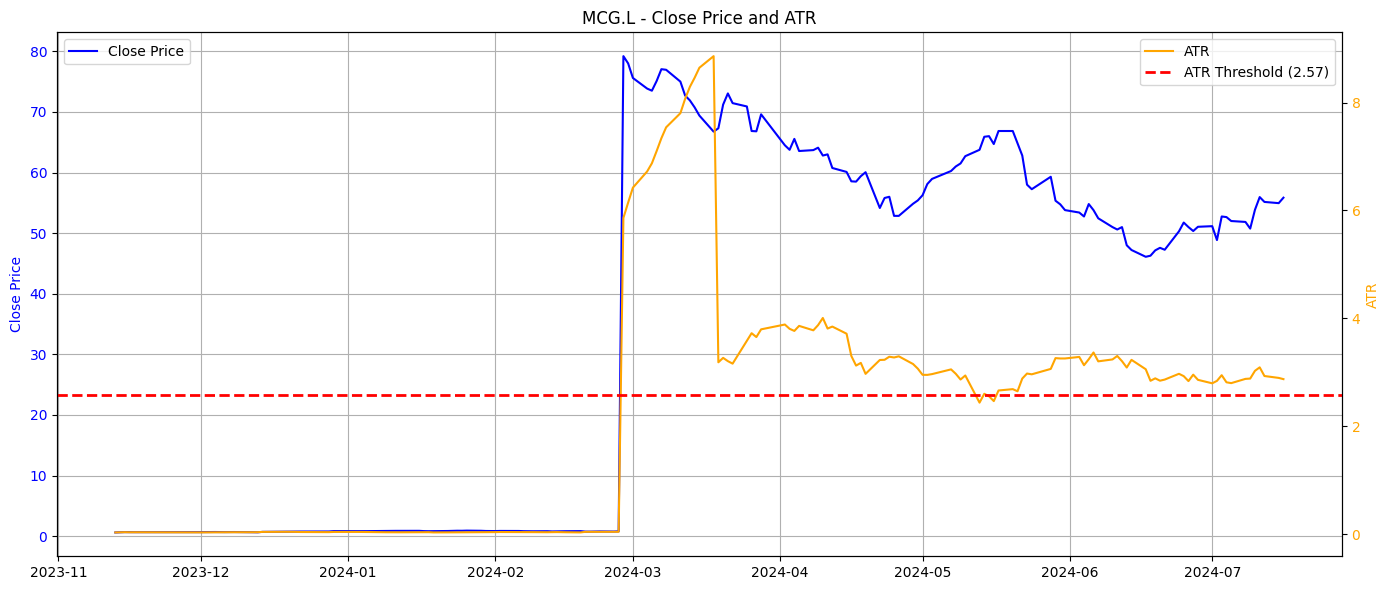

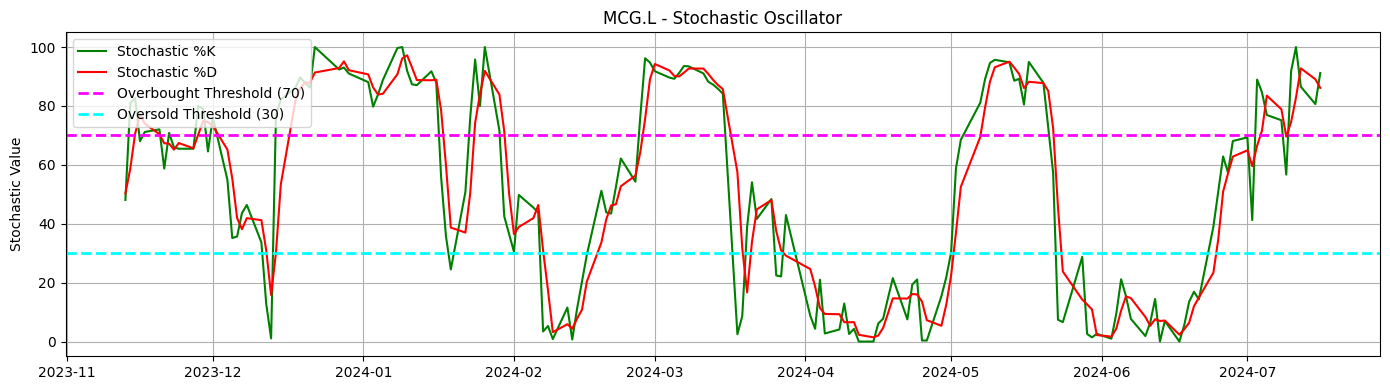

Ticker:                   MCG.L
Company:                  MOBICO GROUP PLC ORD 5P
Sector:                   Industrials
Industry:                 Railroads
Market Cap:               £350,336,096
Shares Outstanding:       614,086,016
52-Week High:             82.3
52-Week Low:              0.5455
PE Ratio (TTM):           N/A
EPS (TTM):                -0.3
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £3,150,899,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £-185,100,000
Total Debt:               £1,579,600,000
Operating Cash Flow (TTM): £230,000,000
Free Cash Flow (TTM):     £232,537,504

Description:              Mobico Group Plc engages in providing public transport services in the United Kingdom, Germany, Spain, Morocco, Bahrain, Switzerland, the United States, Canada, France, and Portugal. The company operates through UK, German Rail, ALSA, and North America segments. It owns and leases vehicles. The company also provides studen

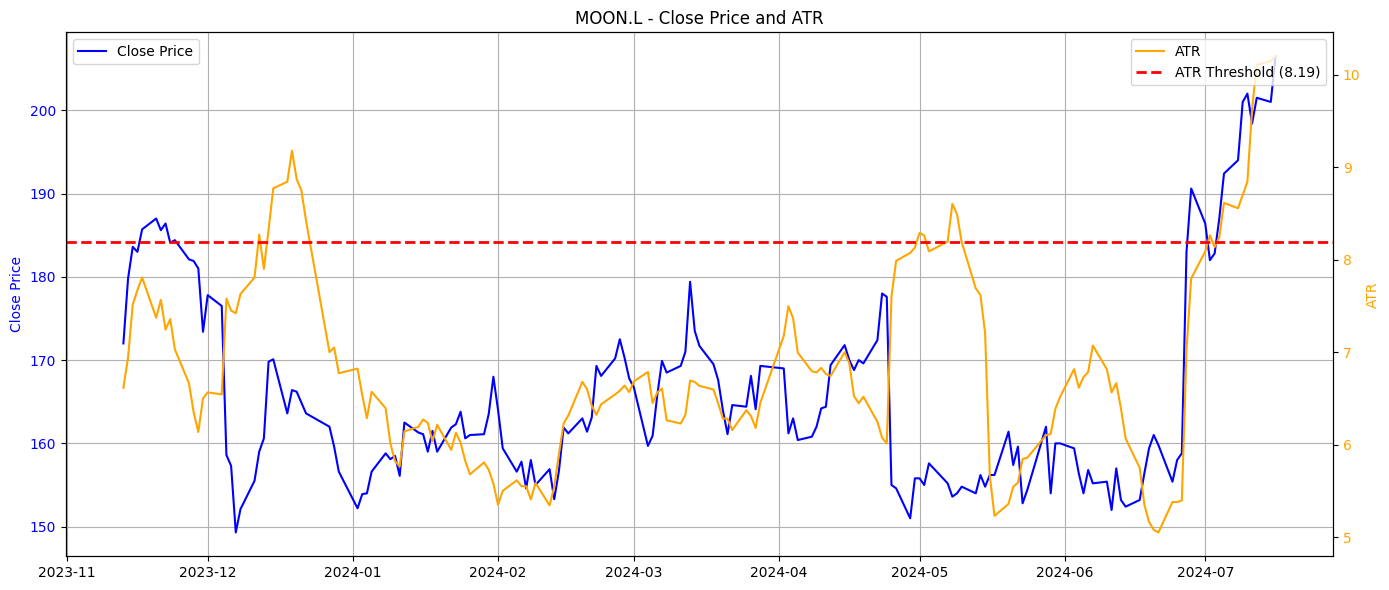

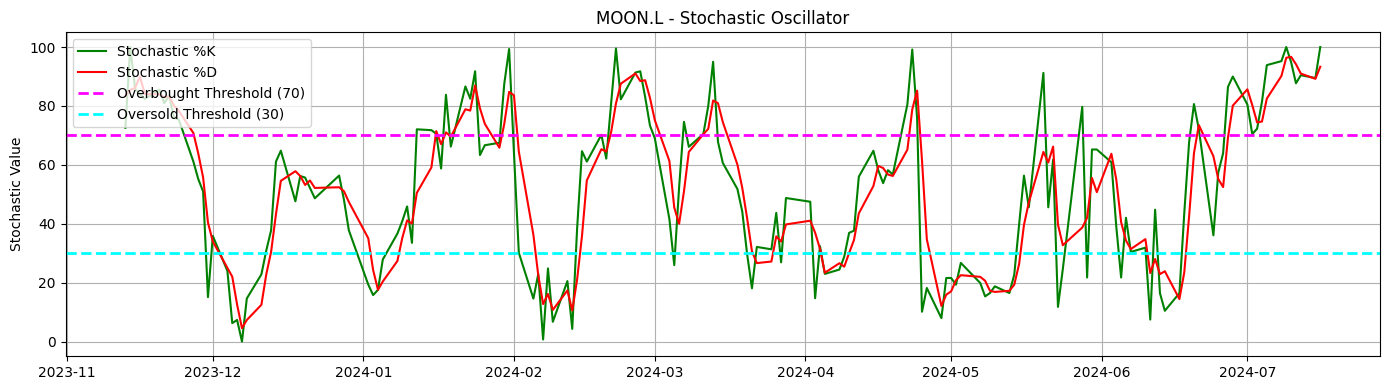

Ticker:                   MOON.L
Company:                  MOONPIG GROUP PLC ORD 10P
Sector:                   Consumer Cyclical
Industry:                 Specialty Retail
Market Cap:               £705,152,768
Shares Outstanding:       344,817,984
52-Week High:             207.0
52-Week Low:              145.6
PE Ratio (TTM):           20.45
EPS (TTM):                0.1
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £341,140,992
Gross Profit (TTM):       N/A
Net Income (TTM):         £34,169,000
Total Debt:               £134,694,000
Operating Cash Flow (TTM): £74,575,000
Free Cash Flow (TTM):     £48,295,752

Description:              Moonpig Group PLC, together with its subsidiaries, provides online greeting cards and gifts in the Netherlands and the United Kingdom. The company sells its products under the Moonpig, Buyagift, Red Letter Days, and Greetz brands through website and mobile app. It also engages in trading activities, as well as off

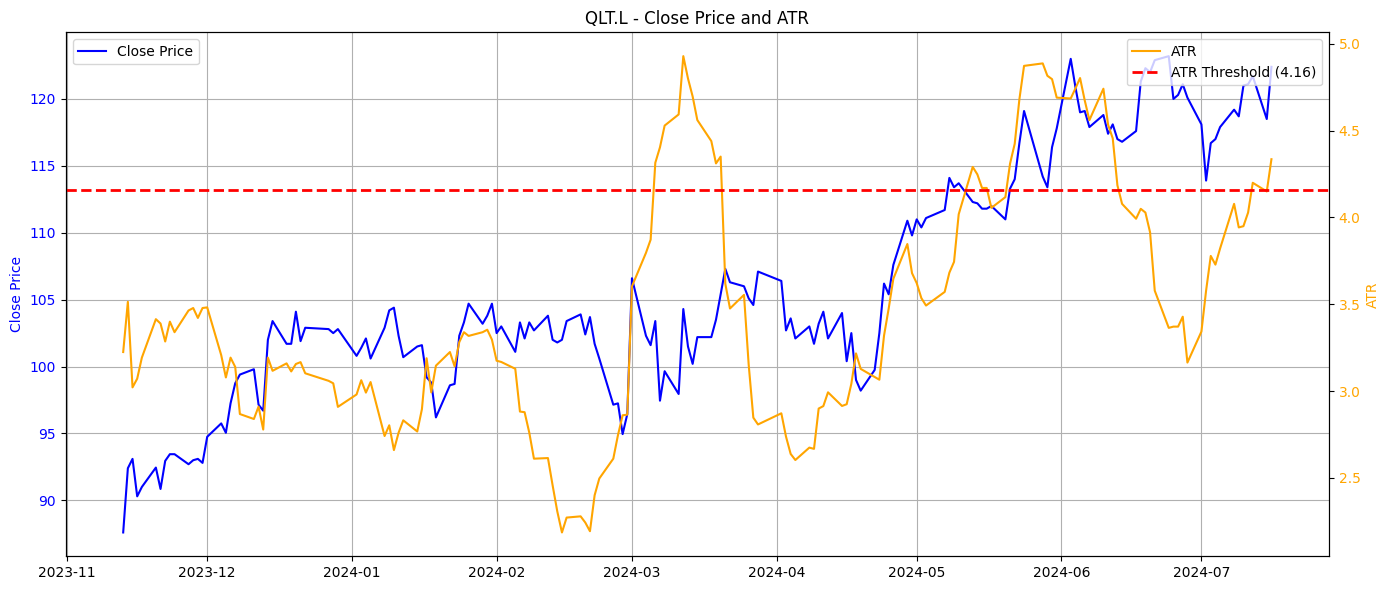

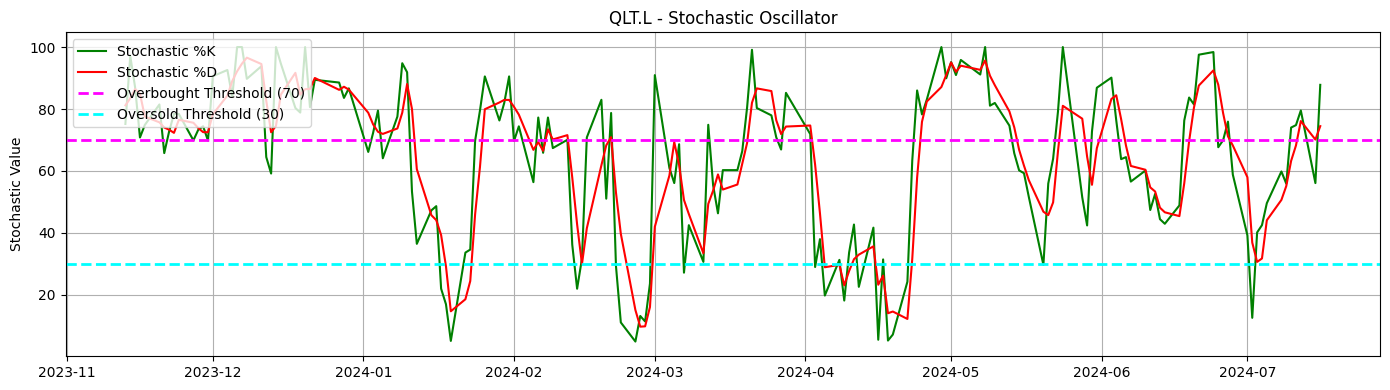

Ticker:                   QLT.L
Company:                  QUILTER PLC ORD 8 1/6P
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £1,703,456,256
Shares Outstanding:       1,388,310,016
52-Week High:             124.5
52-Week Low:              71.2
PE Ratio (TTM):           40.9
EPS (TTM):                0.03
Dividend Yield:           0.0429
Payout Ratio:             1.5483999
Revenue (TTM):            £4,625,999,872
Gross Profit (TTM):       N/A
Net Income (TTM):         £42,000,000
Total Debt:               £279,000,000
Operating Cash Flow (TTM): £2,111,000,064
Free Cash Flow (TTM):     £-1,914,875,008

Description:              Quilter plc provides advice-led investment solutions in the United Kingdom and internationally. It operates through High Net Worth and Affluent segments. The High Net Worth segment provides discretionary investment management services to high-net worth clients, charities, companies, and instituti

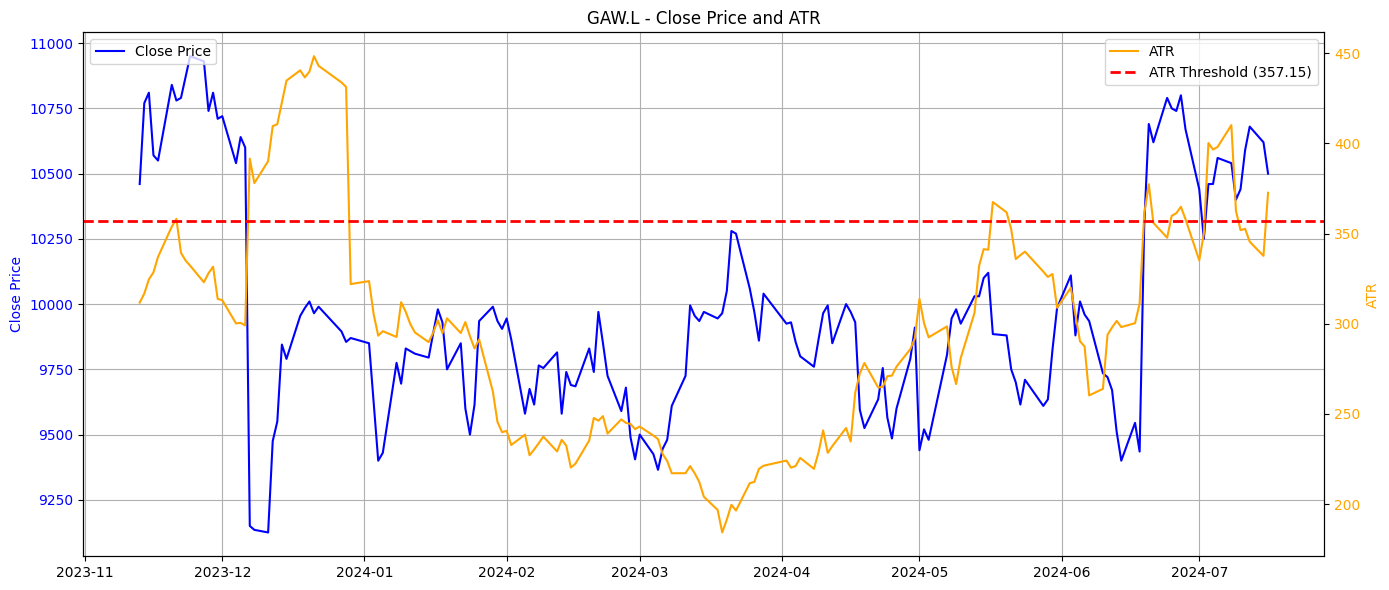

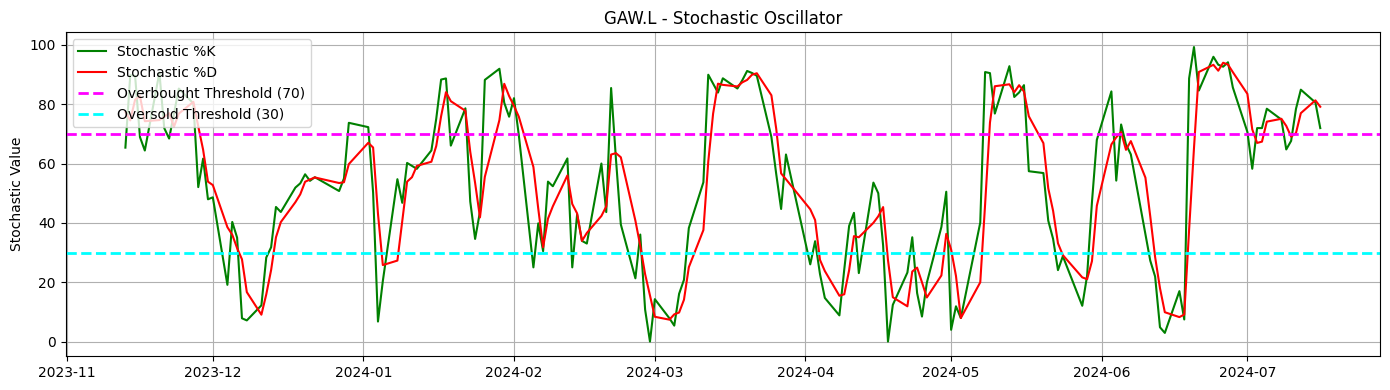

Ticker:                   GAW.L
Company:                  GAMES WORKSHOP GROUP PLC ORD 5P
Sector:                   Consumer Cyclical
Industry:                 Leisure
Market Cap:               £3,420,407,040
Shares Outstanding:       32,951,900
52-Week High:             11850.0
52-Week Low:              8860.0
PE Ratio (TTM):           24.539007
EPS (TTM):                4.23
Dividend Yield:           0.040799998
Payout Ratio:             1.051
Revenue (TTM):            £491,900,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £139,600,000
Total Debt:               £48,600,000
Operating Cash Flow (TTM): £207,900,000
Free Cash Flow (TTM):     £145,500,000

Description:              Games Workshop Group PLC, together with its subsidiaries, designs, manufactures, distributes, and sells miniature figures and games in the United Kingdom, Continental Europe, North America, Australia, New Zealand, Asia, and internationally. It operates in two segments, Core and Licensing. The comp

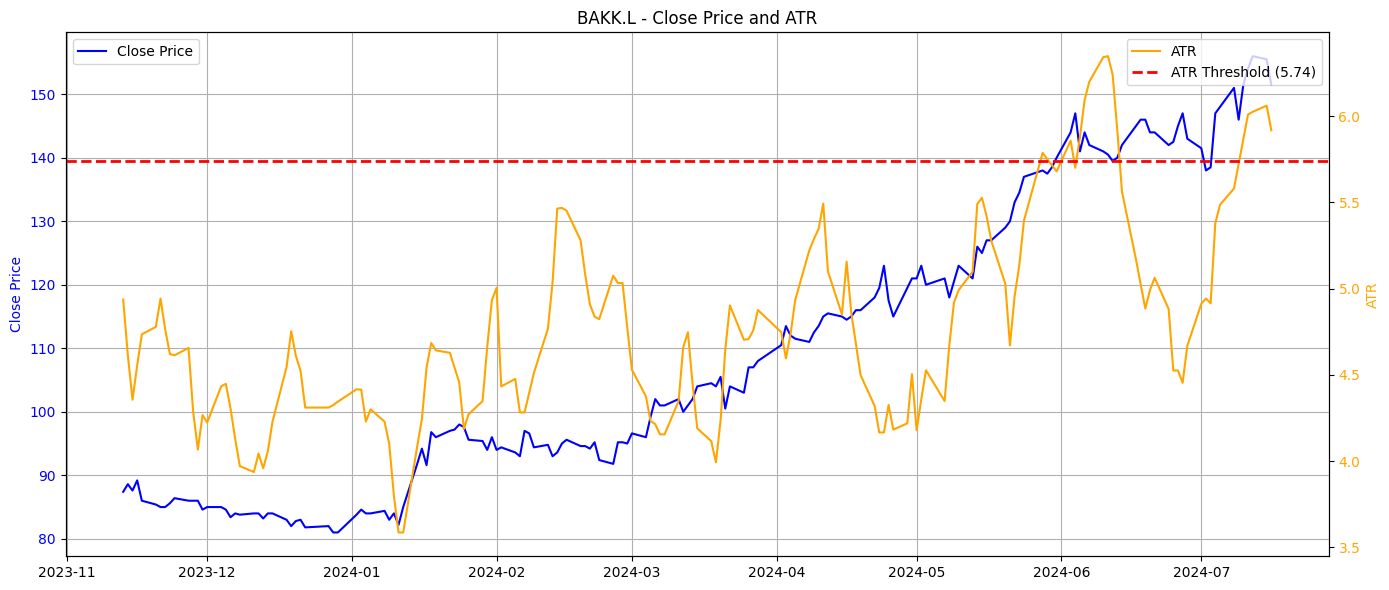

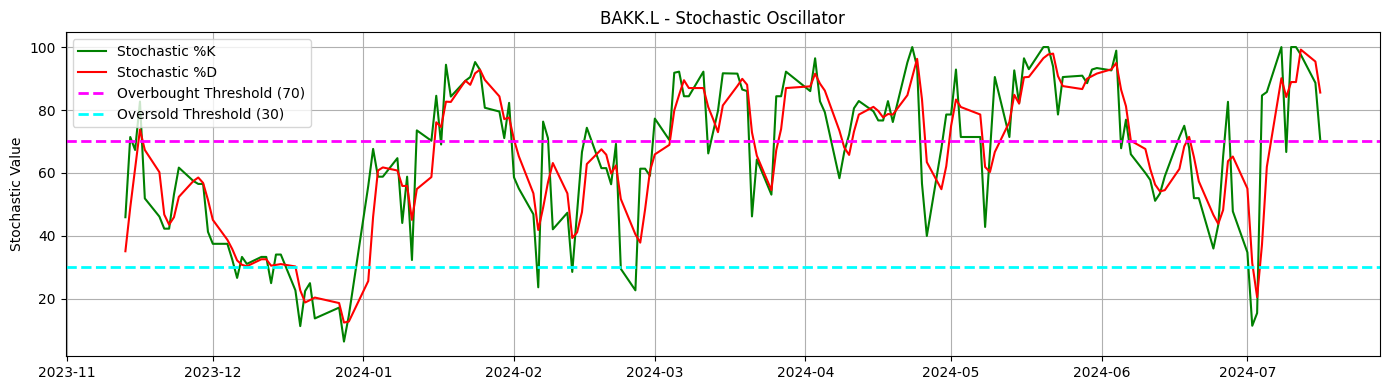

Ticker:                   BAKK.L
Company:                  BAKKAVOR GROUP PLC ORD 2P
Sector:                   Consumer Defensive
Industry:                 Packaged Foods
Market Cap:               £882,407,040
Shares Outstanding:       574,857,984
52-Week High:             158.0
52-Week Low:              80.0
PE Ratio (TTM):           17.055555
EPS (TTM):                0.09
Dividend Yield:           0.047399998
Payout Ratio:             0.7685
Revenue (TTM):            £2,203,800,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £53,900,000
Total Debt:               £356,600,000
Operating Cash Flow (TTM): £147,700,000
Free Cash Flow (TTM):     £89,312,496

Description:              Bakkavor Group plc, together with its subsidiaries, engages in the preparation and marketing of fresh prepared foods in the United Kingdom, the United States, and China. It offers meals, pizzas and breads, desserts, dips, salads, soups, sauces, fresh cut salads, burritos, food-to-go products, sand

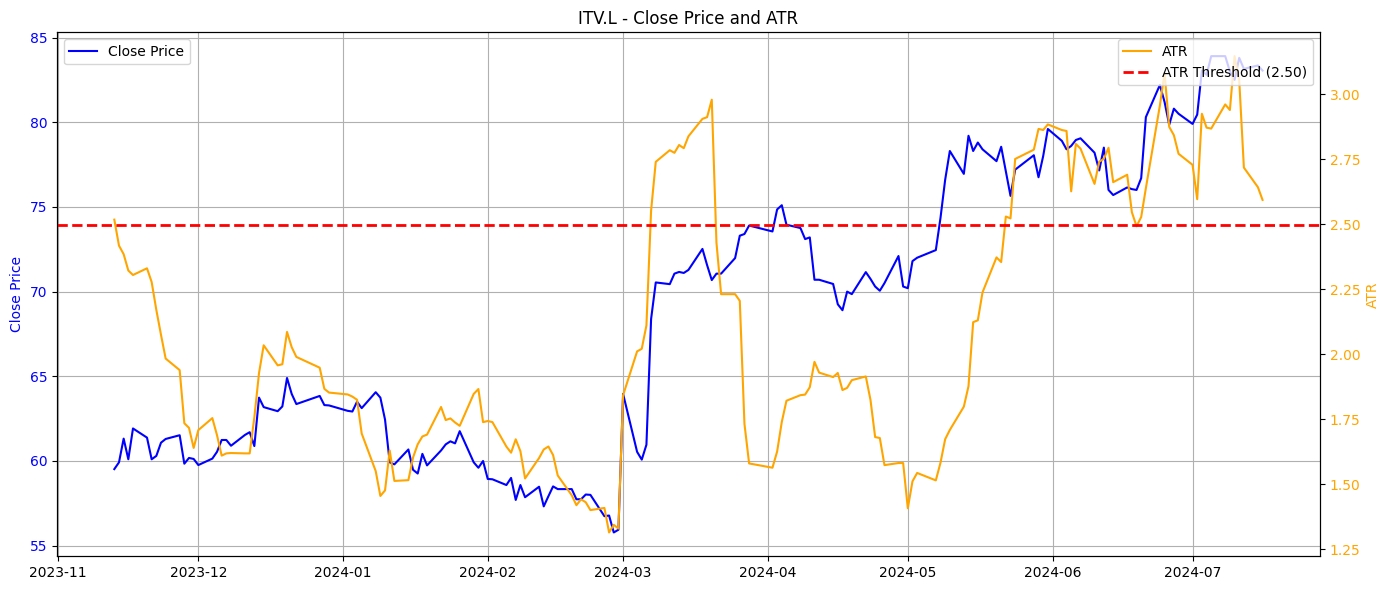

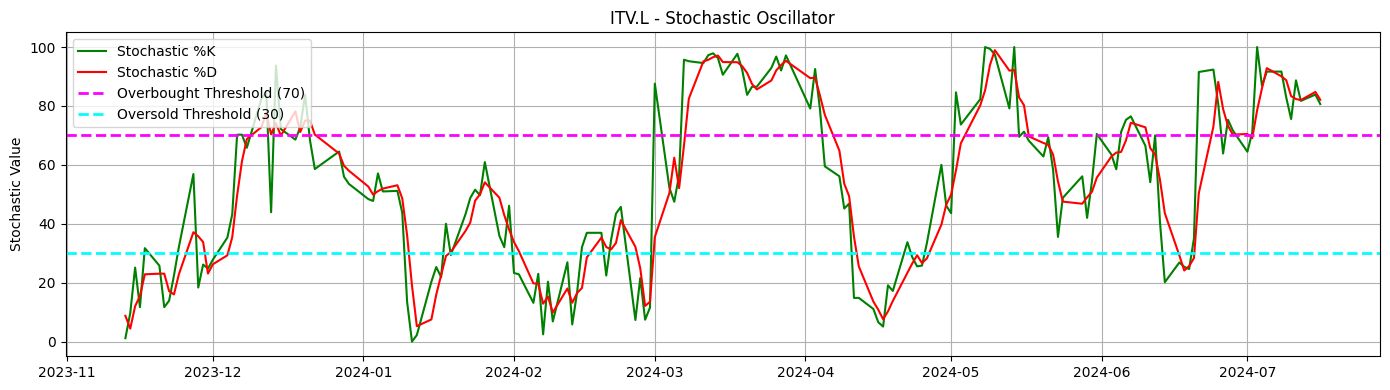

Ticker:                   ITV.L
Company:                  ITV PLC ORD 10P
Sector:                   Communication Services
Industry:                 Broadcasting
Market Cap:               £3,354,430,720
Shares Outstanding:       3,957,609,984
52-Week High:             84.95
52-Week Low:              55.49
PE Ratio (TTM):           16.9518
EPS (TTM):                0.05
Dividend Yield:           0.06
Payout Ratio:             0.9615
Revenue (TTM):            £3,624,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £210,000,000
Total Debt:               £893,000,000
Operating Cash Flow (TTM): £385,000,000
Free Cash Flow (TTM):     £272,500,000

Description:              ITV plc, an integrated production, broadcasting, and streaming company, which creates, owns, and distributes content on various platforms worldwide. It operates through ITV Studios and Media & Entertainment segments. The ITV Studios segment creates and produces programs and formats that include sports, drama

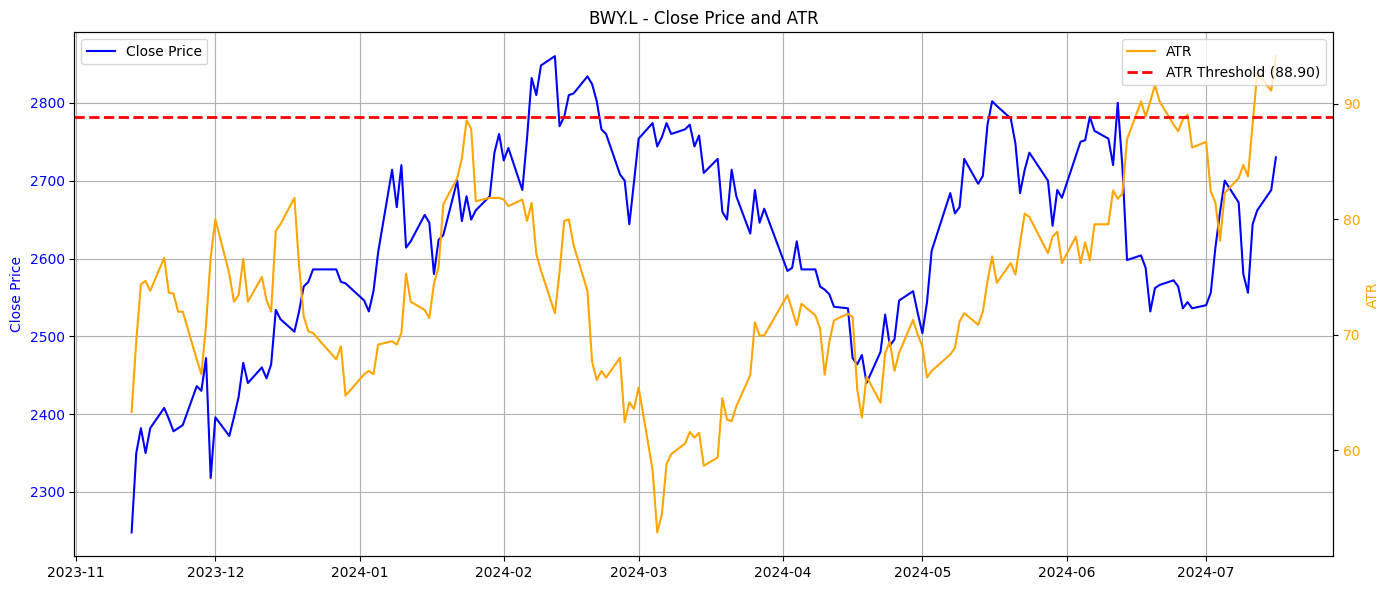

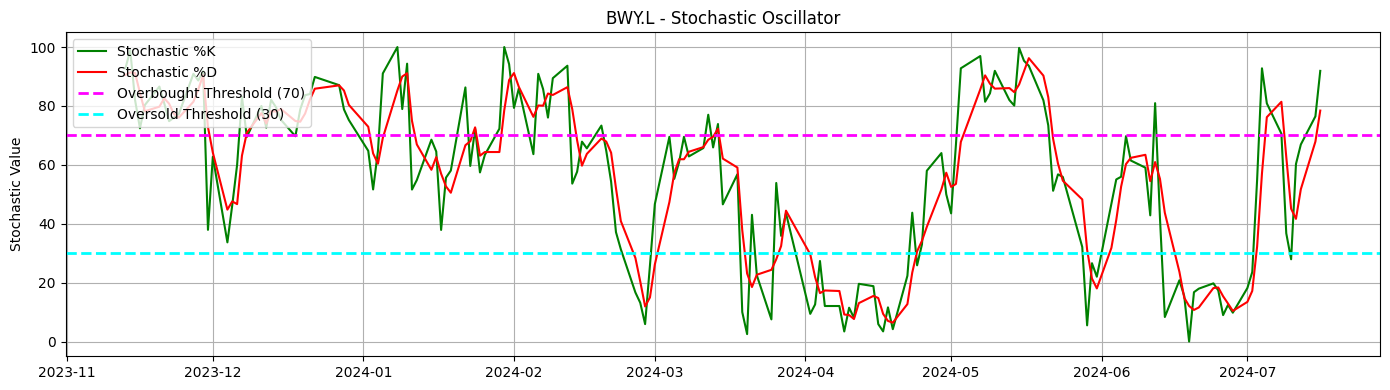

Ticker:                   BWY.L
Company:                  BELLWAY PLC ORD 12.5P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £3,227,361,536
Shares Outstanding:       118,653,000
52-Week High:             2898.0
52-Week Low:              1972.0
PE Ratio (TTM):           15.111112
EPS (TTM):                1.8
Dividend Yield:           0.040999997
Payout Ratio:             0.7765
Revenue (TTM):            £2,870,400,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £219,000,000
Total Debt:               £130,000,000
Operating Cash Flow (TTM): £66,800,000
Free Cash Flow (TTM):     £104,812,496

Description:              Bellway p.l.c., together with its subsidiaries, engages in the home building business in the United Kingdom. The company builds and sells homes ranging from one-bedroom apartments to six-bedroom family homes, as well as provides homes to housing associations for social housing. It offers 

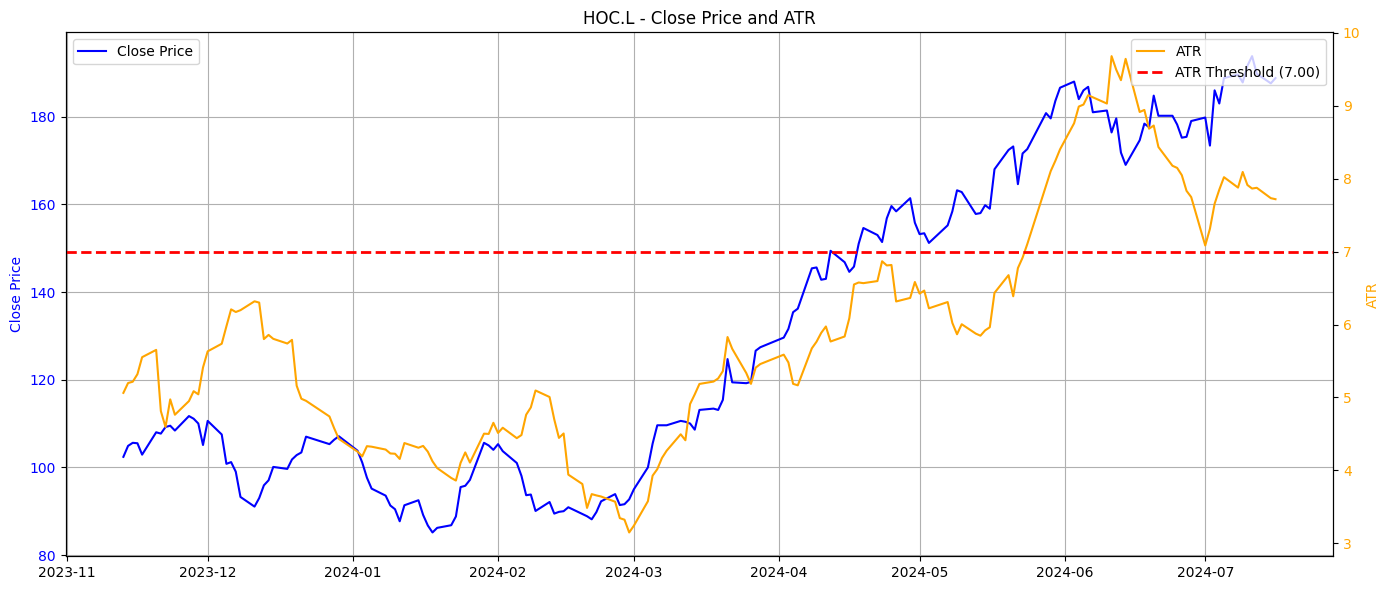

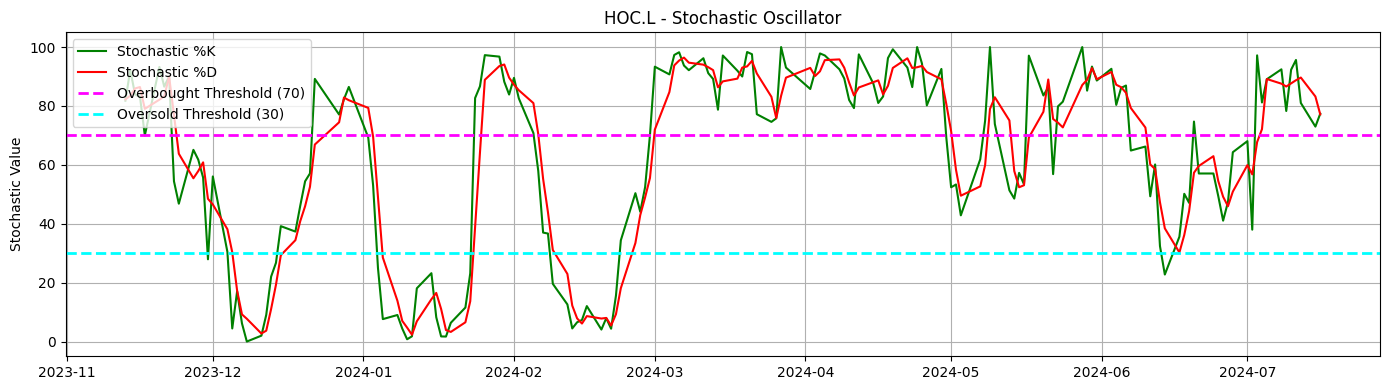

Ticker:                   HOC.L
Company:                  HOCHSCHILD MINING PLC ORD 1P
Sector:                   Basic Materials
Industry:                 Gold
Market Cap:               £948,660,480
Shares Outstanding:       514,457,984
52-Week High:             195.0
52-Week Low:              72.0
PE Ratio (TTM):           N/A
EPS (TTM):                -0.08
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £693,715,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £-55,006,000
Total Debt:               £351,156,000
Operating Cash Flow (TTM): £178,760,992
Free Cash Flow (TTM):     £-73,425,504

Description:              Hochschild Mining plc, a precious metals company, engages in the exploration, mining, processing, and sale of gold and silver deposits in Peru, Argentina, the United States, Canada, Brazil, and Chile. The company's flagship asset include the Inmaculada gold and silver underground mine located in the Ayacucho Department, sou

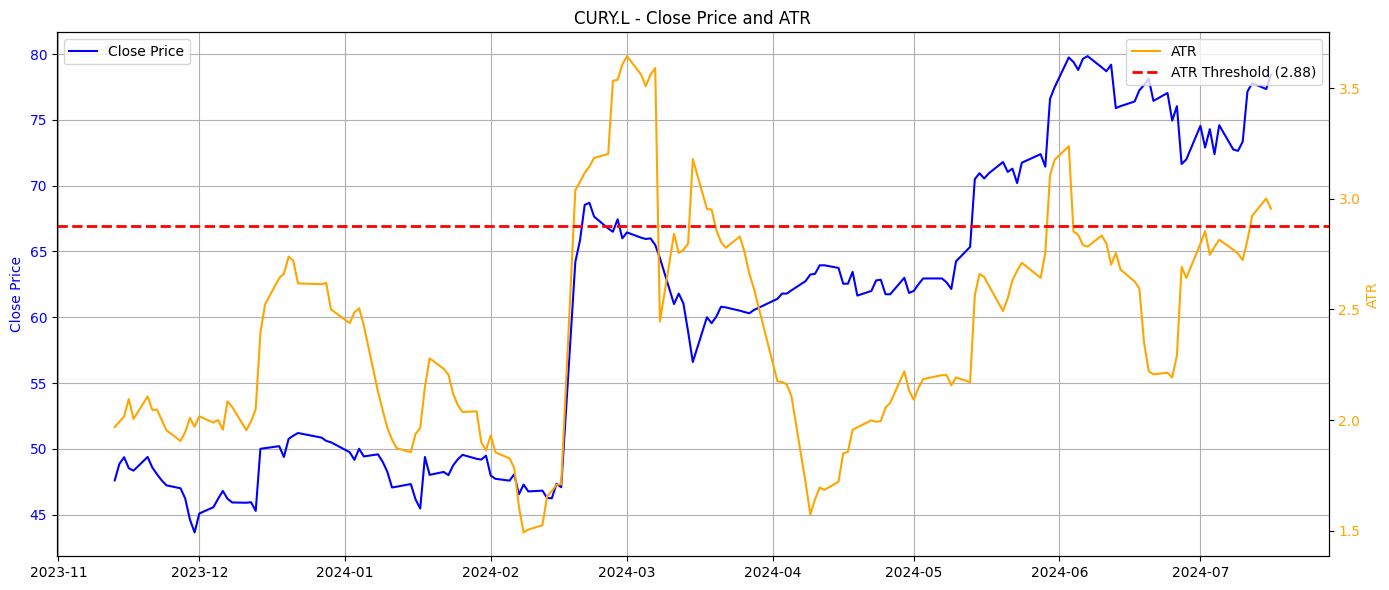

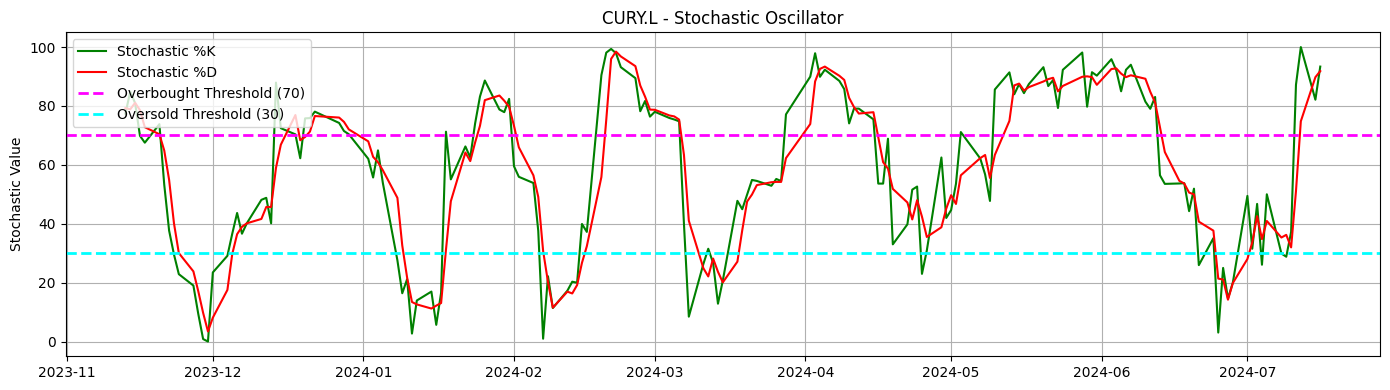

Ticker:                   CURY.L
Company:                  CURRYS PLC ORD 0.1P
Sector:                   Consumer Cyclical
Industry:                 Specialty Retail
Market Cap:               £879,588,224
Shares Outstanding:       1,133,490,048
52-Week High:             81.3
52-Week Low:              43.02
PE Ratio (TTM):           38.8
EPS (TTM):                0.02
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £8,476,000,256
Gross Profit (TTM):       N/A
Net Income (TTM):         £27,000,000
Total Debt:               £1,032,000,000
Operating Cash Flow (TTM): £366,000,000
Free Cash Flow (TTM):     £173,500,000

Description:              Currys plc operates as a retailer of technology products and services. It offers consumer electronics and mobile technology products and services; and mobile virtual network operator and consumer electrical repair services. The company also sells its products through online; and offers insurance services. The com

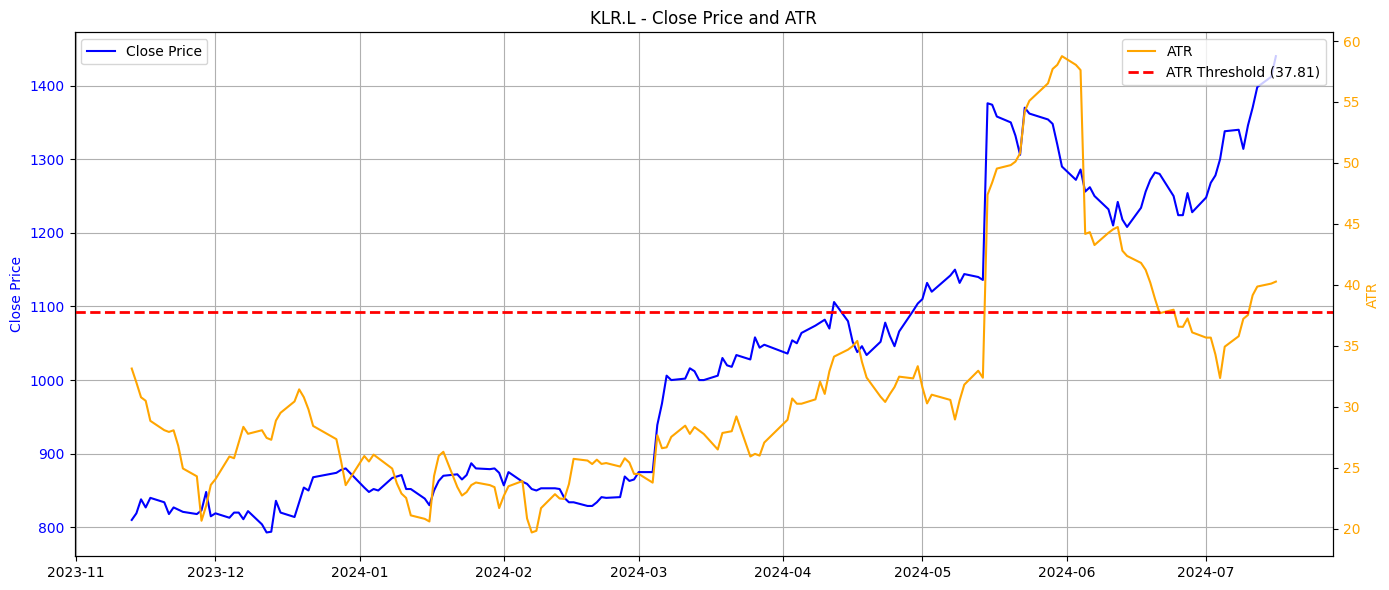

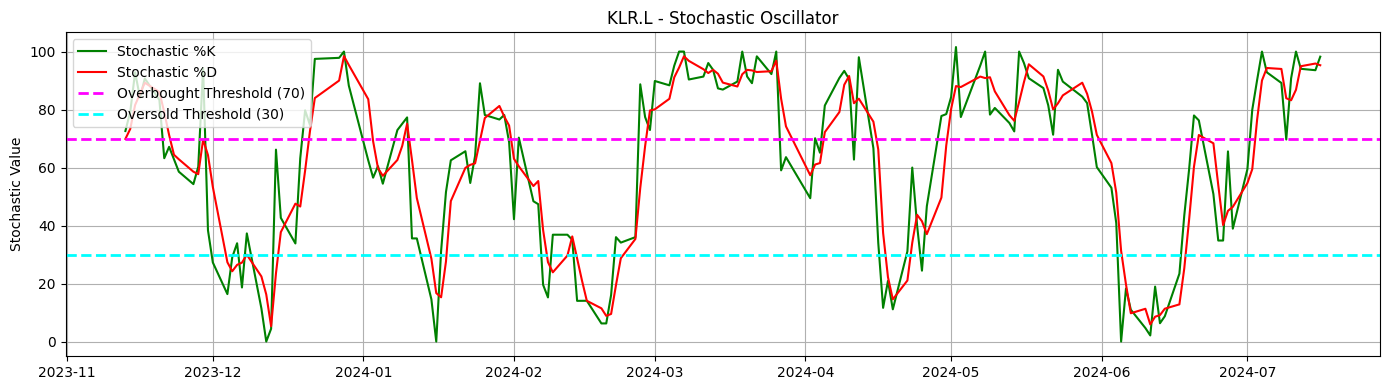

Ticker:                   KLR.L
Company:                  KELLER GROUP PLC ORD 10P
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £1,060,034,752
Shares Outstanding:       72,439,400
52-Week High:             1478.0
52-Week Low:              672.0
PE Ratio (TTM):           12.194499
EPS (TTM):                1.2
Dividend Yield:           0.0315
Payout Ratio:             0.31870002
Revenue (TTM):            £2,966,000,128
Gross Profit (TTM):       N/A
Net Income (TTM):         £89,400,000
Total Debt:               £388,700,000
Operating Cash Flow (TTM): £197,000,000
Free Cash Flow (TTM):     £144,324,992

Description:              Keller Group plc provides specialist geotechnical services in North America, Europe, the Asia-Pacific, the Middle East, and Africa. The company offers ground improvement services, grouting, deep foundations, earth retention, marine, and instrumentation and monitoring services, as well as post

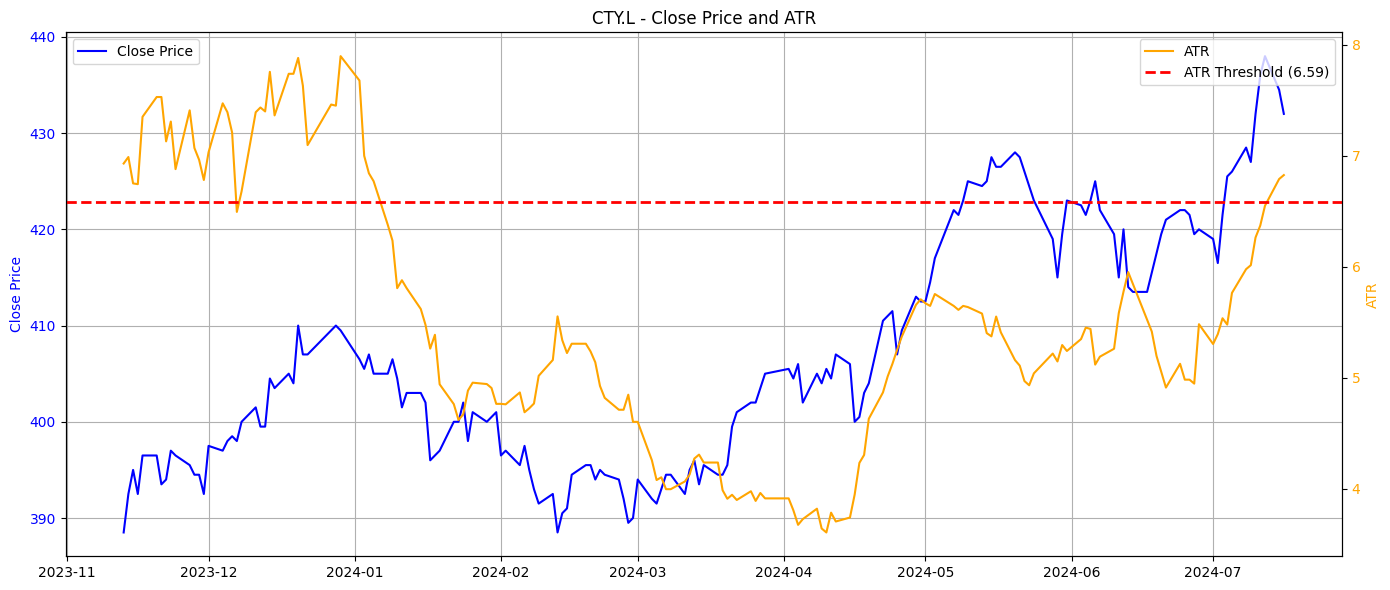

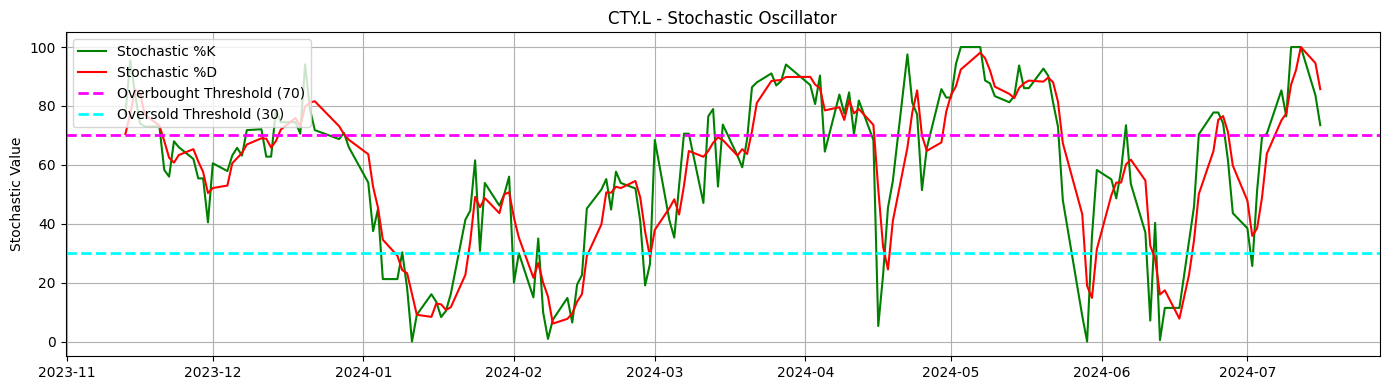

Ticker:                   CTY.L
Company:                  CITY OF LONDON INVESTMENT TRUST
Sector:                   N/A
Industry:                 N/A
Market Cap:               £2,163,234,816
Shares Outstanding:       N/A
52-Week High:             439.0
52-Week Low:              371.5
PE Ratio (TTM):           17.5042
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


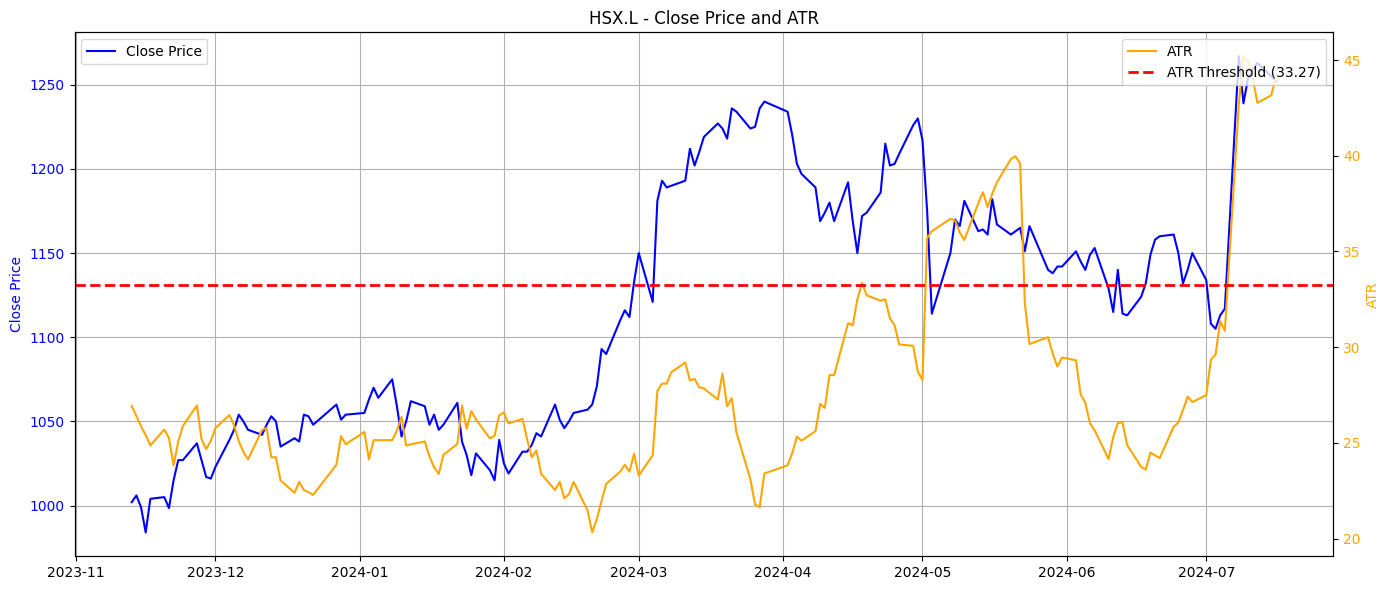

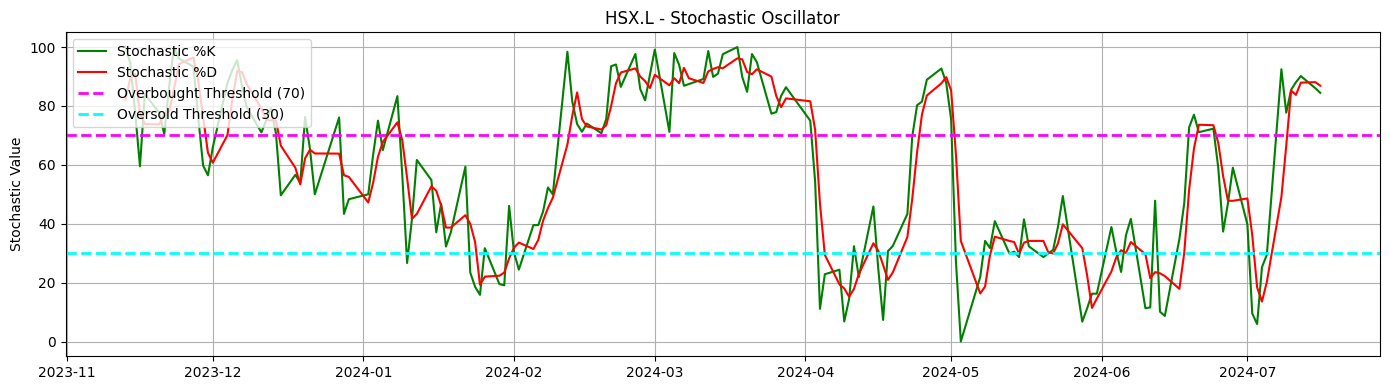

Ticker:                   HSX.L
Company:                  HISCOX LTD ORD 6.5P (DI)
Sector:                   Financial Services
Industry:                 Insurance - Property & Casualty
Market Cap:               £4,301,186,560
Shares Outstanding:       340,823,008
52-Week High:             1282.0
52-Week Low:              926.035
PE Ratio (TTM):           8.141935
EPS (TTM):                1.55
Dividend Yield:           0.0234
Payout Ratio:             0.1839
Revenue (TTM):            £3,699,599,872
Gross Profit (TTM):       N/A
Net Income (TTM):         £712,000,000
Total Debt:               £754,200,000
Operating Cash Flow (TTM): £232,100,000
Free Cash Flow (TTM):     £698,475,008

Description:              Hiscox Ltd, through its subsidiaries, provides insurance and reinsurance services in the United Kingdom, Europe, the United States, and internationally. The company operates through four segments: Hiscox Retail, Hiscox London Market, Hiscox Re & ILS, and Corporate Centre. It offer

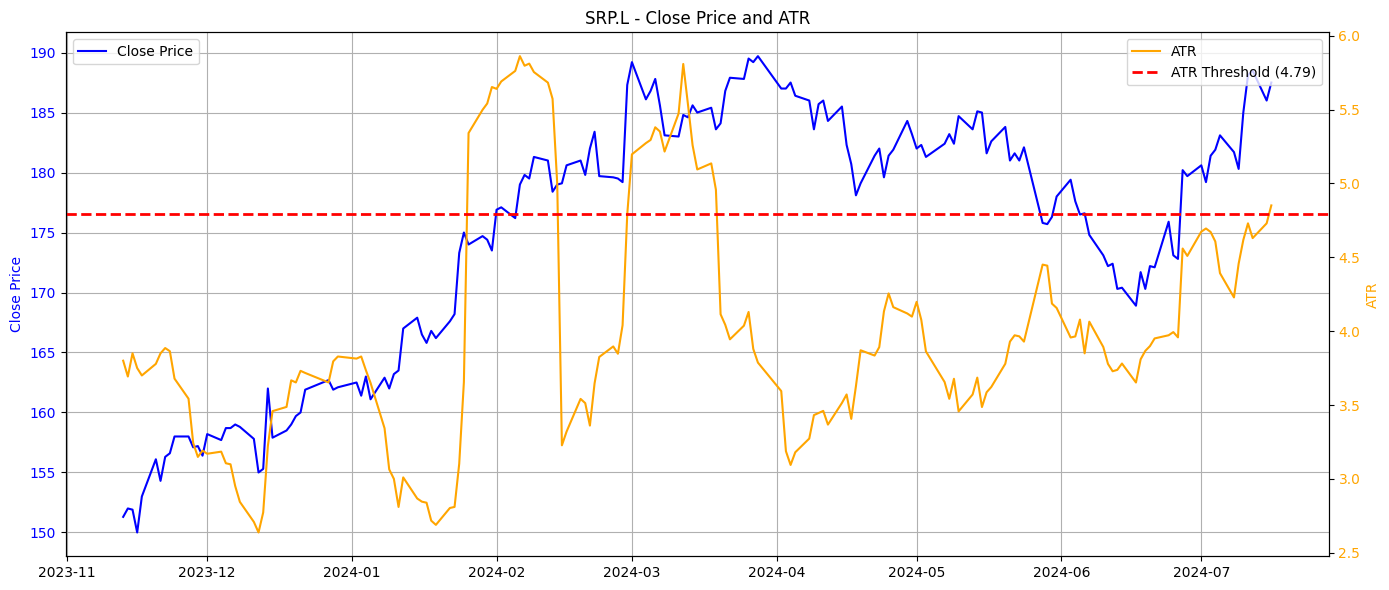

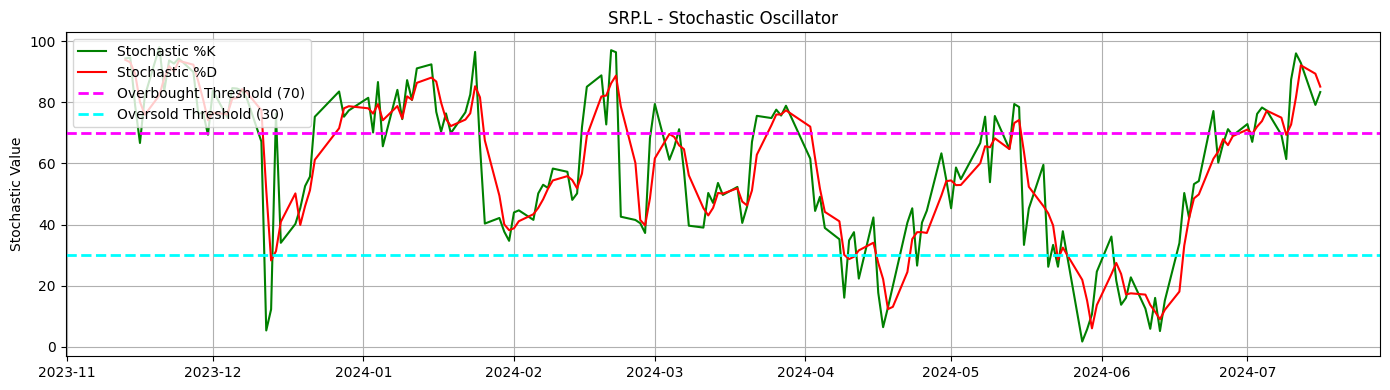

Ticker:                   SRP.L
Company:                  SERCO GROUP PLC ORD 2P
Sector:                   Industrials
Industry:                 Specialty Business Services
Market Cap:               £1,987,412,352
Shares Outstanding:       1,058,259,968
52-Week High:             193.1
52-Week Low:              138.0
PE Ratio (TTM):           10.433333
EPS (TTM):                0.18
Dividend Yield:           0.0183
Payout Ratio:             0.1707
Revenue (TTM):            £4,873,800,192
Gross Profit (TTM):       N/A
Net Income (TTM):         £202,400,000
Total Debt:               £659,900,032
Operating Cash Flow (TTM): £393,100,000
Free Cash Flow (TTM):     £203,262,496

Description:              Serco Group plc provides public services in the United Kingdom, Europe, North America, the Asia Pacific, and the Middle East. It offers service design and advisory, resourcing, programmes management, systems integration, case management, engineering, and assets and facilities management servic

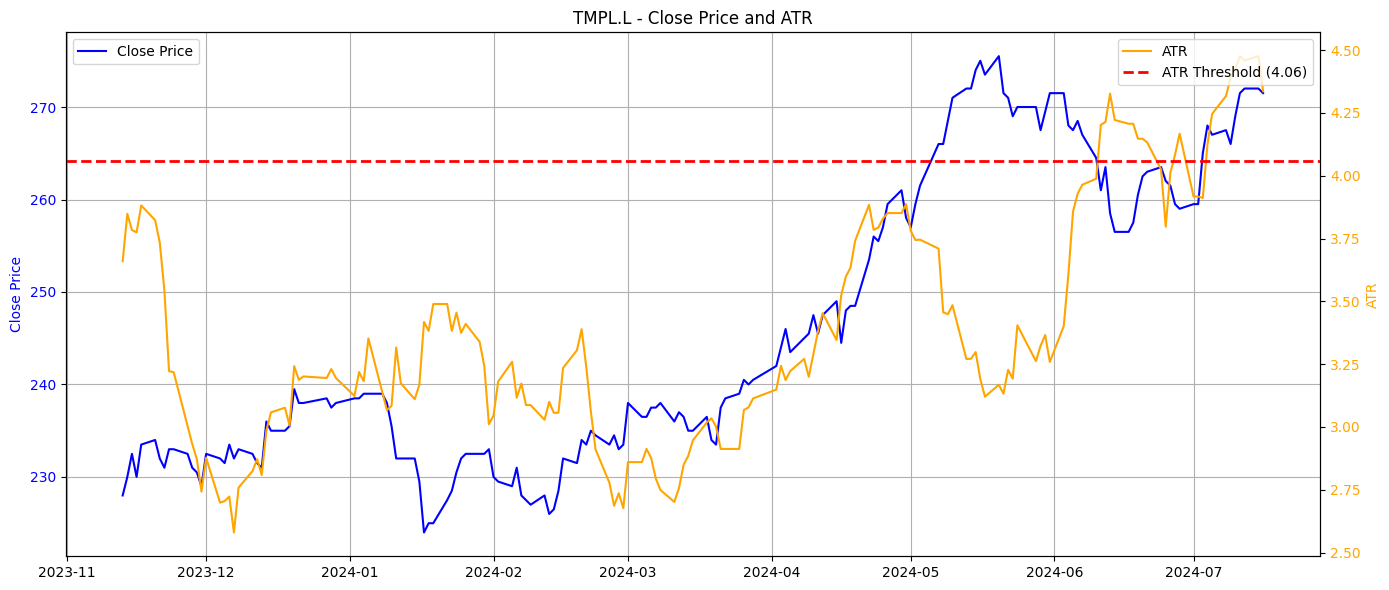

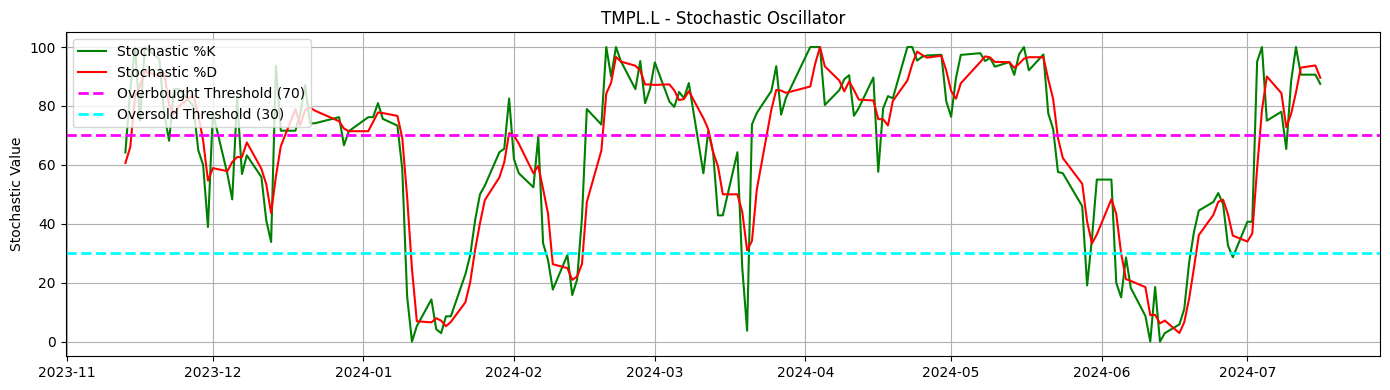

Ticker:                   TMPL.L
Company:                  TEMPLE BAR INVESTMENT TRUST PLC
Sector:                   N/A
Industry:                 N/A
Market Cap:               £786,113,408
Shares Outstanding:       N/A
52-Week High:             276.0
52-Week Low:              222.0
PE Ratio (TTM):           9.461028
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


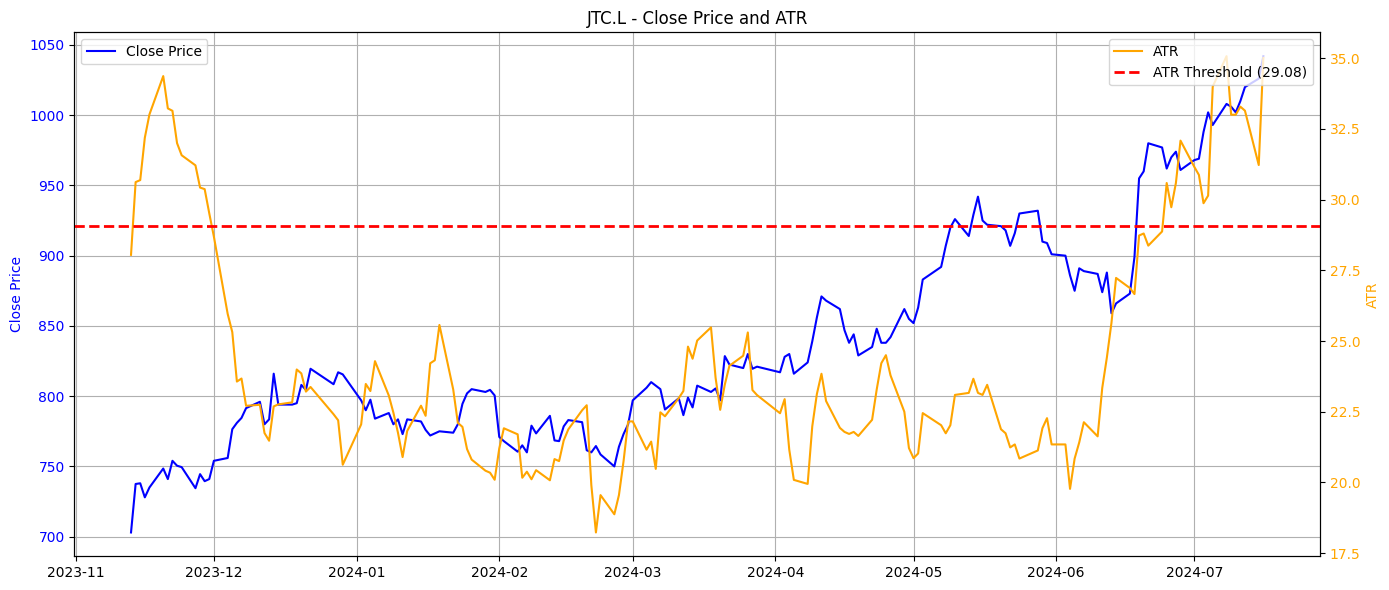

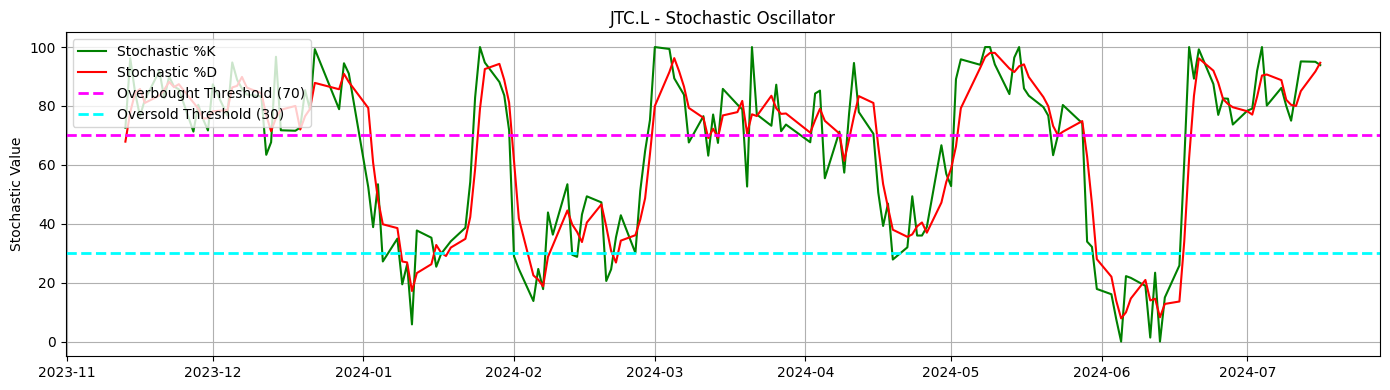

Ticker:                   JTC.L
Company:                  JTC PLC ORD GBP0.01
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £1,694,326,144
Shares Outstanding:       163,544,992
52-Week High:             1050.0
52-Week Low:              623.5
PE Ratio (TTM):           74.0
EPS (TTM):                0.14
Dividend Yield:           0.0109
Payout Ratio:             0.7377
Revenue (TTM):            £257,440,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £21,821,000
Total Debt:               £264,572,000
Operating Cash Flow (TTM): £81,293,000
Free Cash Flow (TTM):     £84,566,624

Description:              JTC PLC provides fund, corporate, and private wealth services to institutional and private clients. The company operates in two segments, Institutional Client Services and Private Client Services. It offers fund services in a range of asset classes, including real estate, private equity, renewables, hedge, debt

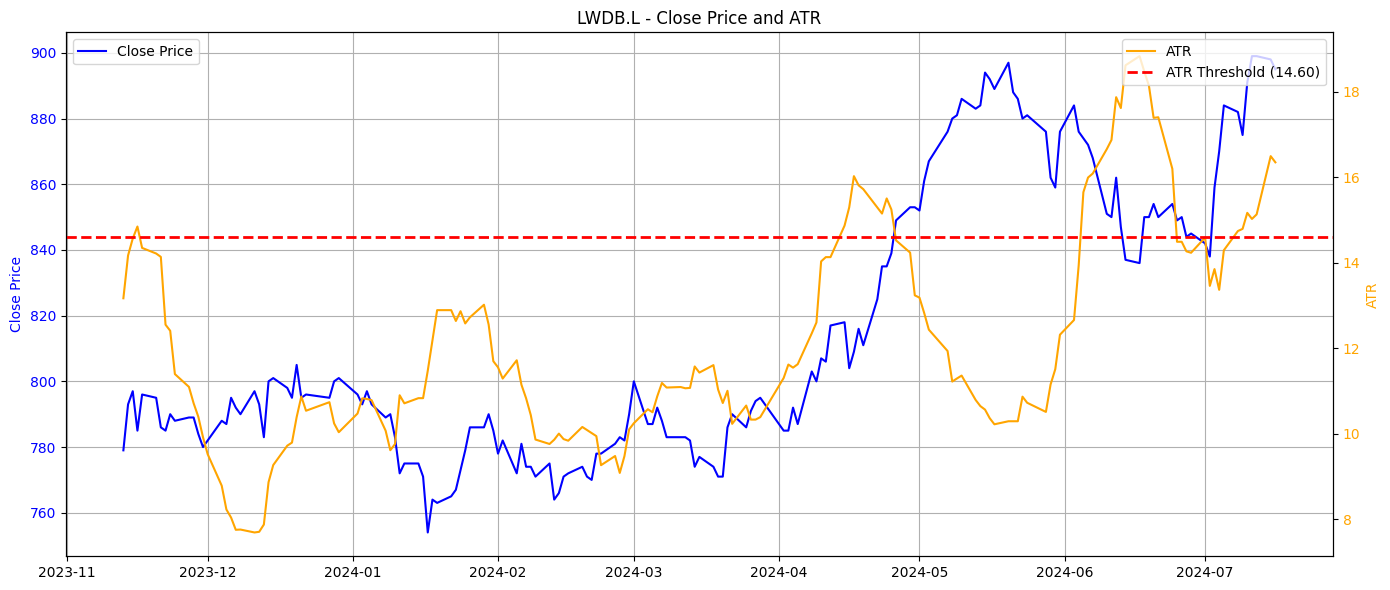

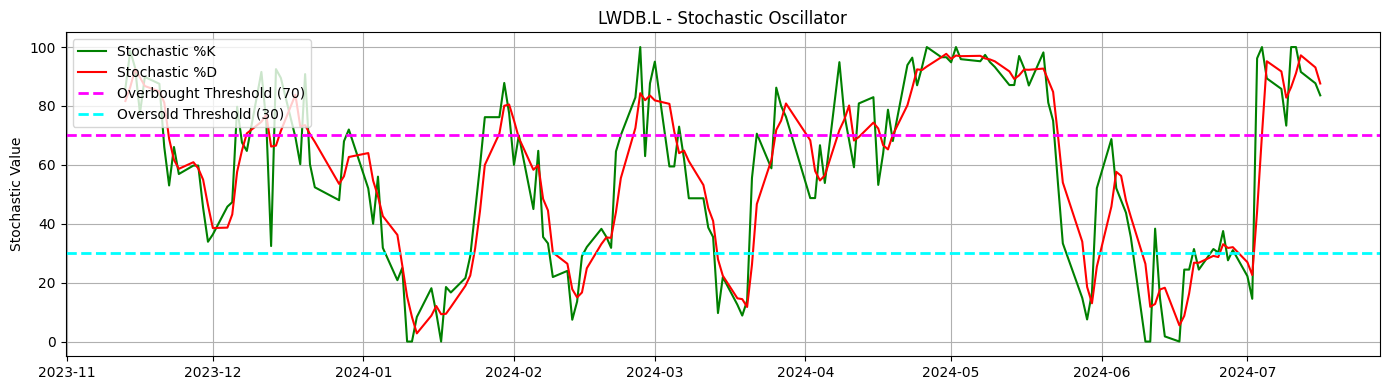

Ticker:                   LWDB.L
Company:                  LAW DEBENTURE CORPORATION PLC O
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,172,729,344
Shares Outstanding:       N/A
52-Week High:             907.0
52-Week Low:              718.04
PE Ratio (TTM):           15.481035
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


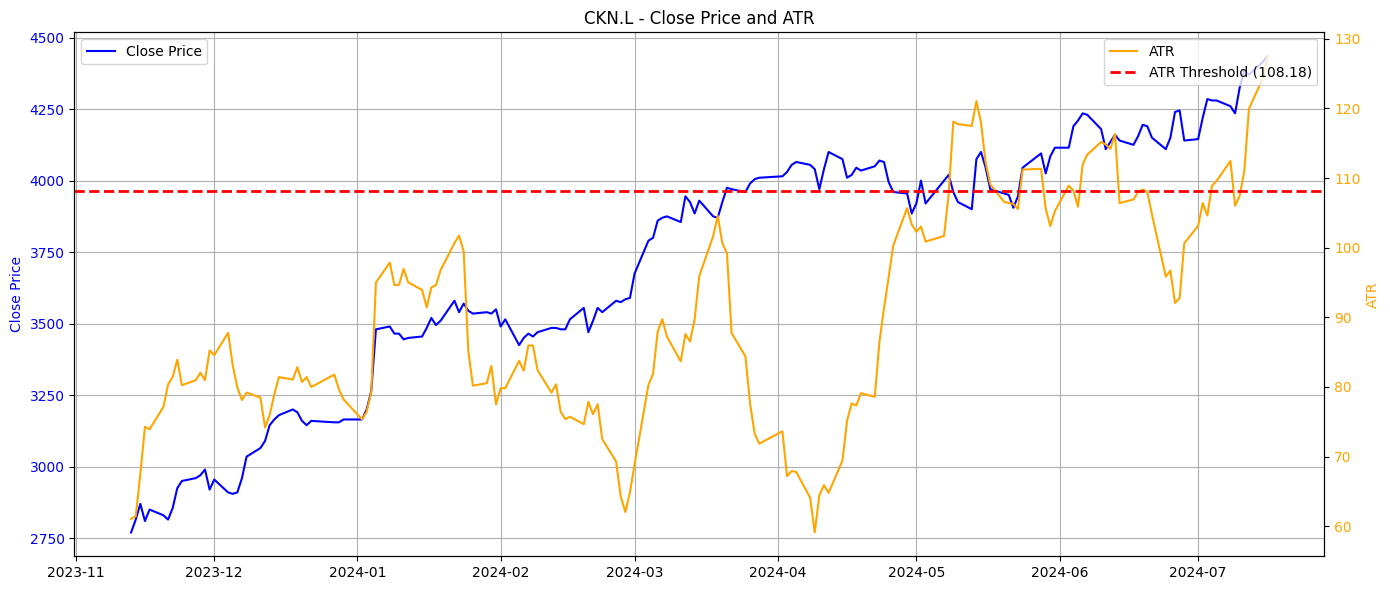

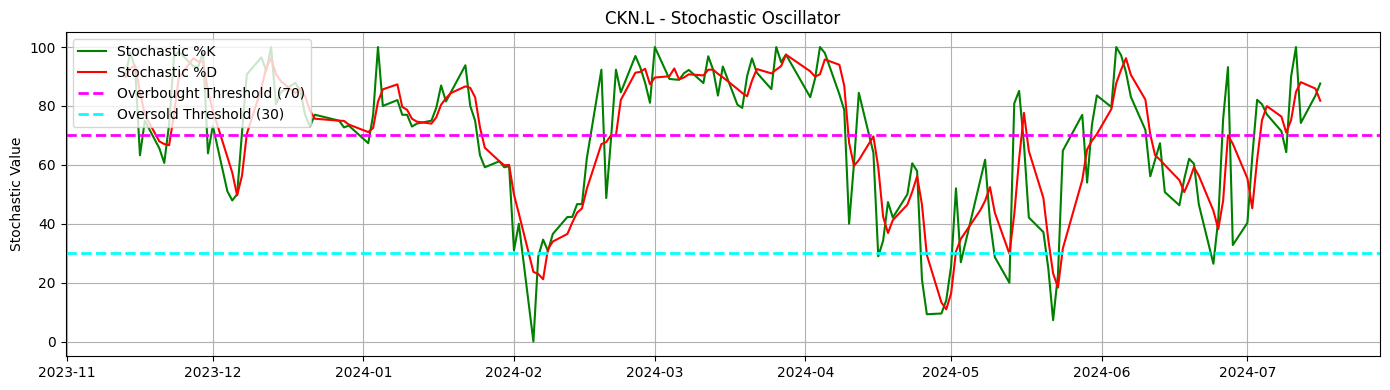

Ticker:                   CKN.L
Company:                  CLARKSON PLC ORD 25P
Sector:                   Industrials
Industry:                 Marine Shipping
Market Cap:               £1,373,644,160
Shares Outstanding:       30,661,700
52-Week High:             4520.0
52-Week Low:              2500.0
PE Ratio (TTM):           16.350365
EPS (TTM):                2.74
Dividend Yield:           0.0228
Payout Ratio:             0.3436
Revenue (TTM):            £639,400,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £83,800,000
Total Debt:               £43,200,000
Operating Cash Flow (TTM): £155,300,000
Free Cash Flow (TTM):     £80,387,504

Description:              Clarkson PLC provides integrated shipping services worldwide. The company's Broking segment offers services to shipowners and charterers in the transportation of various cargoes by sea; and to buyers and sellers/yards related to sale and purchase transactions, as well as futures broking operation. Its Financial s

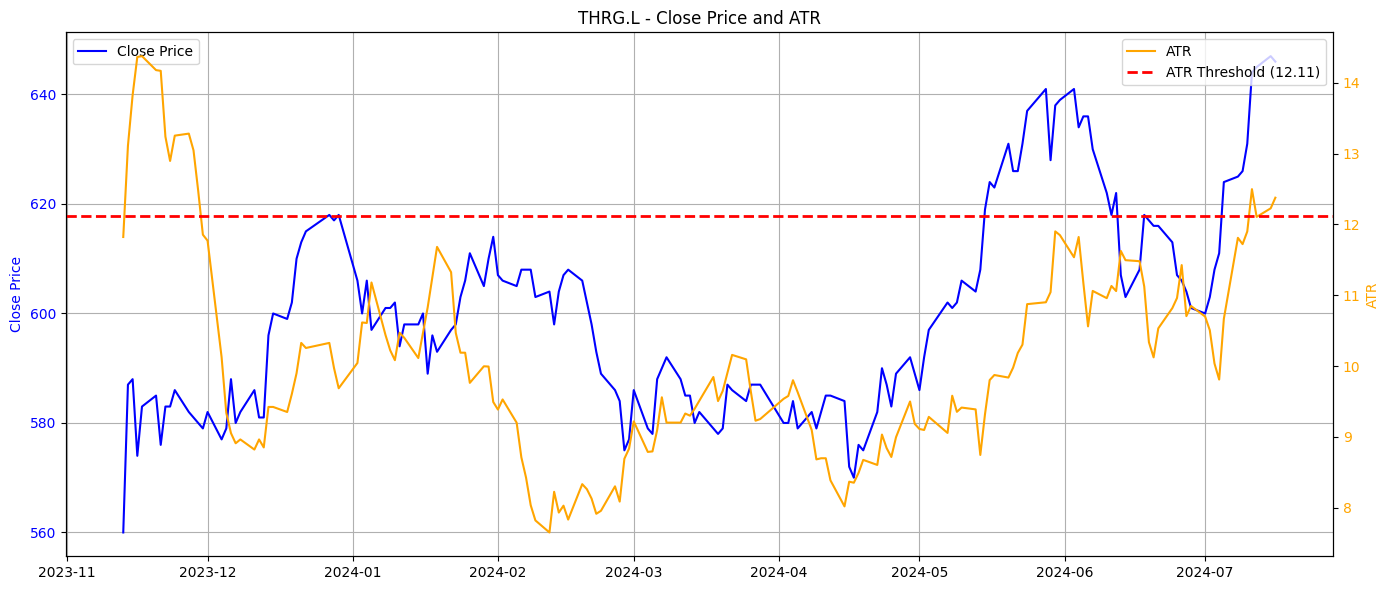

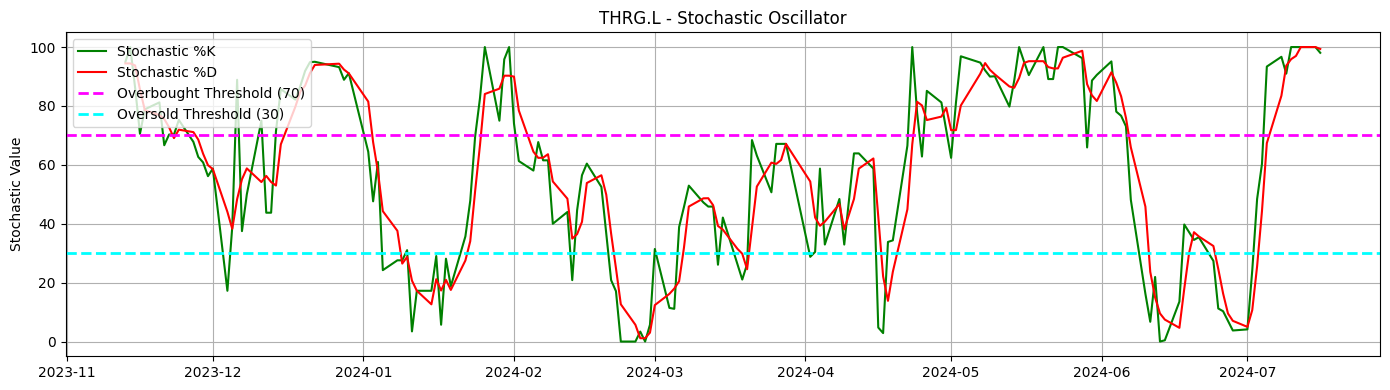

Ticker:                   THRG.L
Company:                  BLACKROCK THROGMORTON TRUST PLC
Sector:                   N/A
Industry:                 N/A
Market Cap:               £591,148,992
Shares Outstanding:       N/A
52-Week High:             663.98
52-Week Low:              503.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


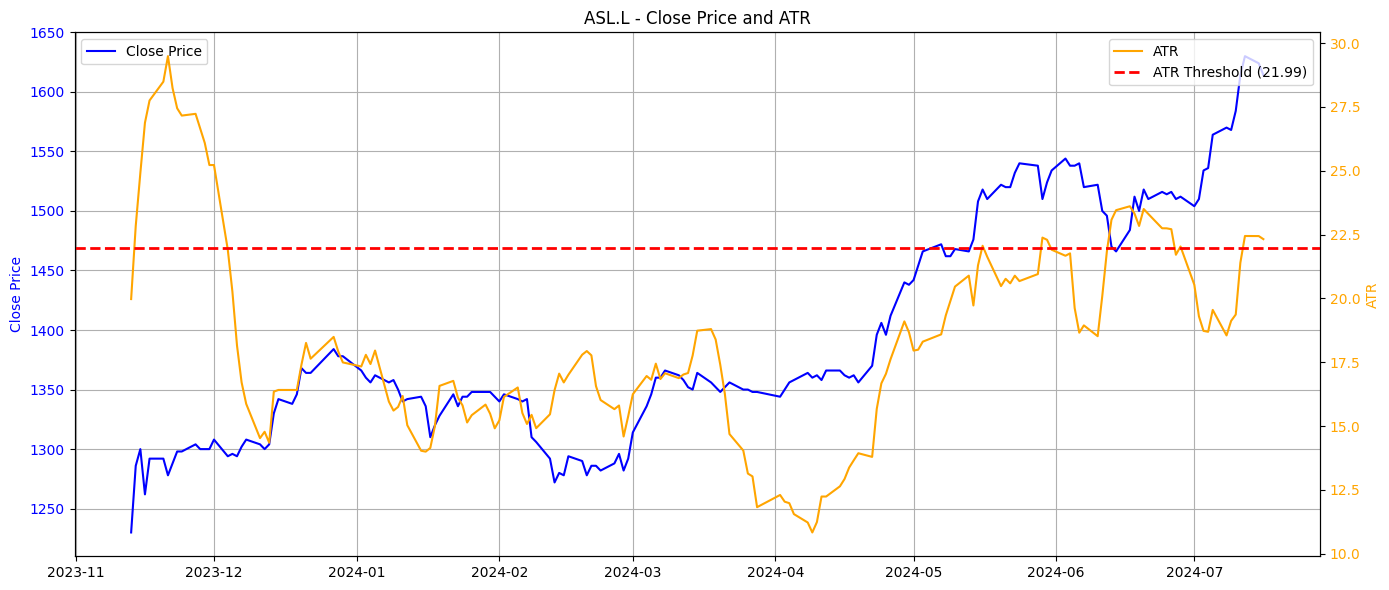

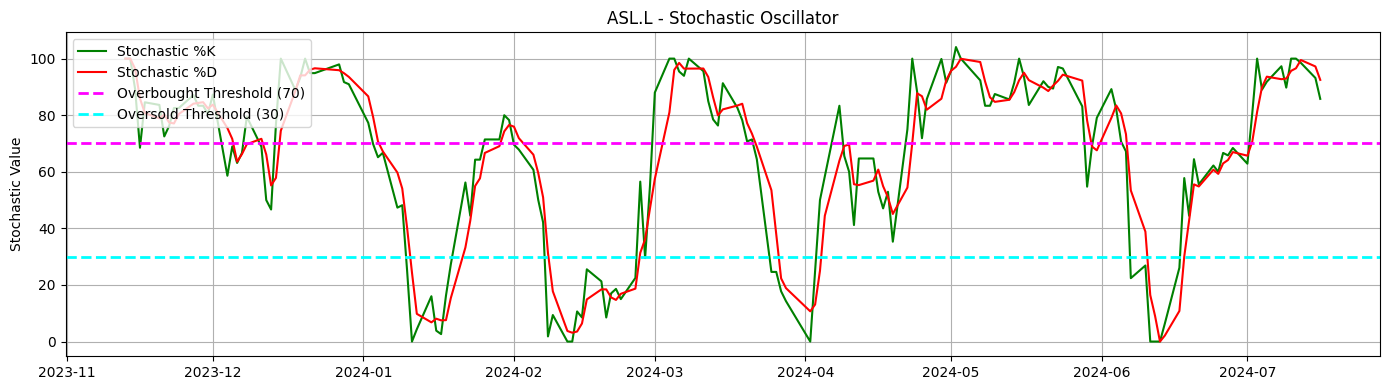

Ticker:                   ASL.L
Company:                  ABERFORTH SMALLER COMPANIES TRU
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,375,682,432
Shares Outstanding:       N/A
52-Week High:             1666.59
52-Week Low:              1126.0
PE Ratio (TTM):           13.9743595
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


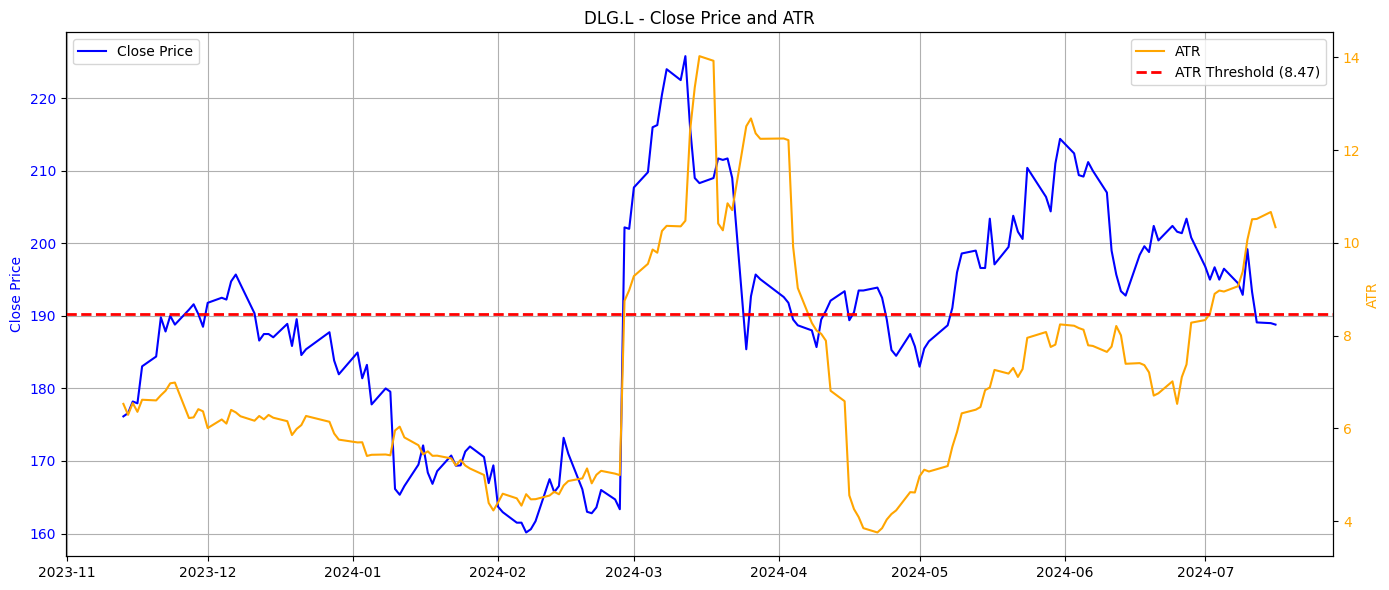

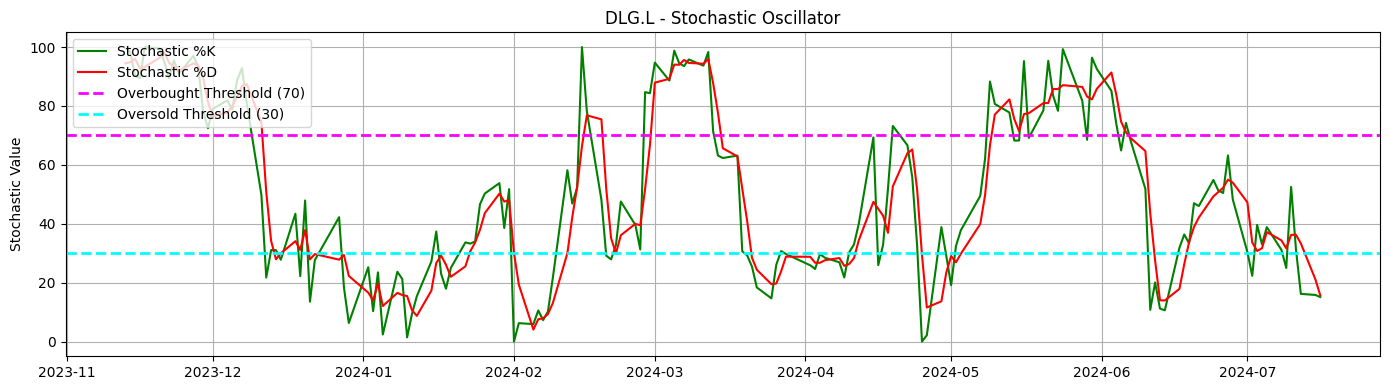

Ticker:                   DLG.L
Company:                  DIRECT LINE INSURANCE GROUP PLC
Sector:                   Financial Services
Industry:                 Insurance - Property & Casualty
Market Cap:               £2,473,416,192
Shares Outstanding:       1,297,699,968
52-Week High:             240.1
52-Week Low:              145.65
PE Ratio (TTM):           11.9125
EPS (TTM):                0.16
Dividend Yield:           0.042
Payout Ratio:             0.0
Revenue (TTM):            £3,270,599,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £206,300,000
Total Debt:               £454,200,000
Operating Cash Flow (TTM): £404,900,000
Free Cash Flow (TTM):     £-199,300,000

Description:              Direct Line Insurance Group plc engages in the provision of general insurance products and services in the United Kingdom. The company operates through Motor, Home, Rescue and Other Personal Lines, and Commercial segments. It offers motor, home, van, landlord, rescue, pet, trad

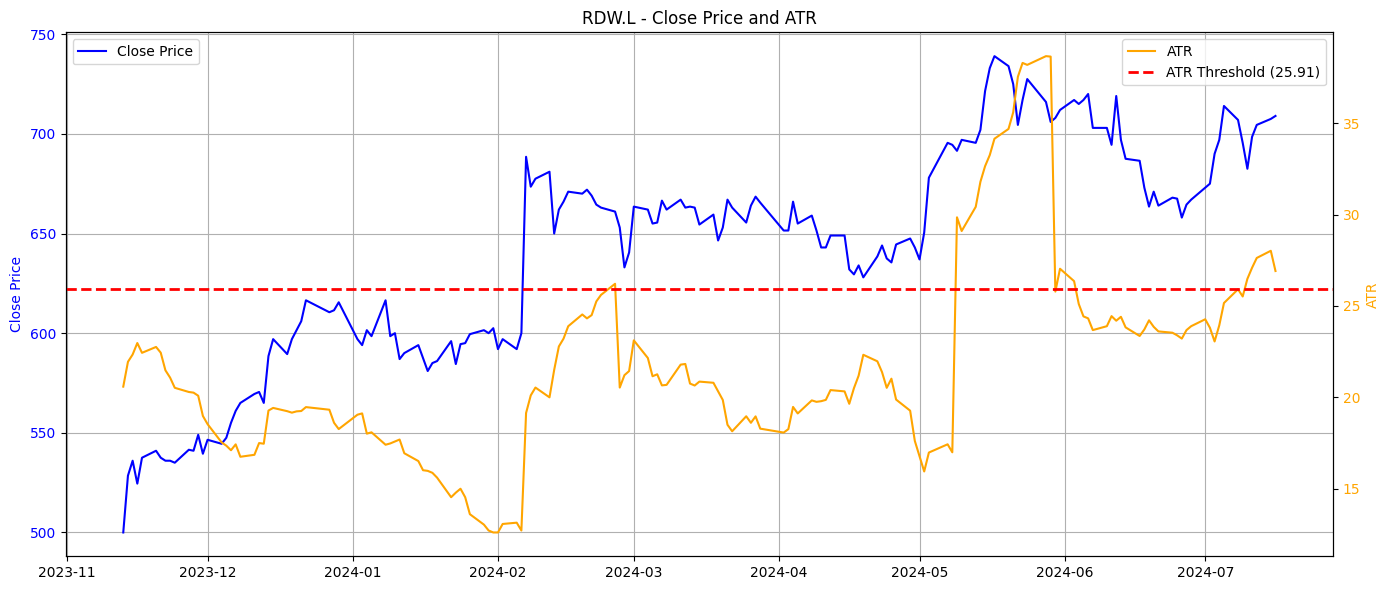

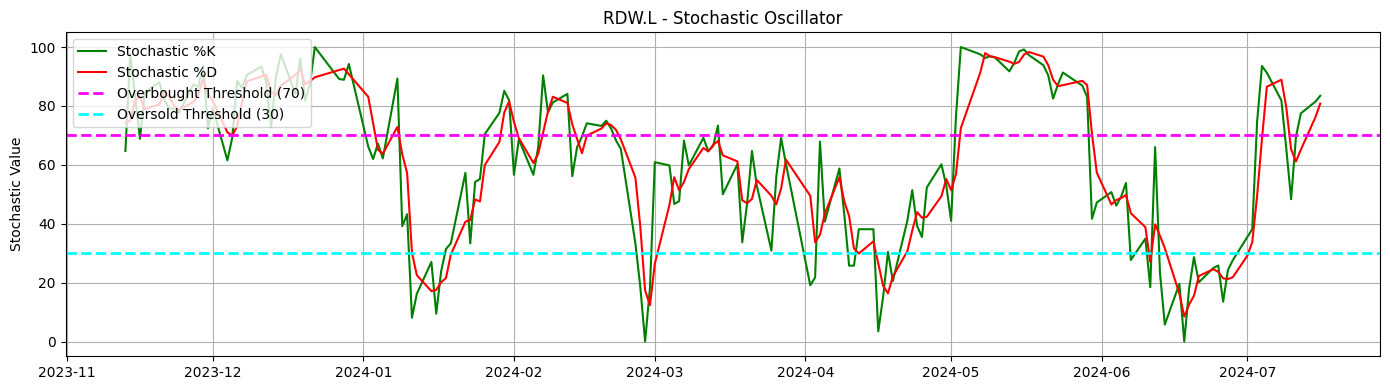

Ticker:                   RDW.L
Company:                  REDROW PLC ORD 10.5P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £2,346,812,928
Shares Outstanding:       330,769,984
52-Week High:             750.0
52-Week Low:              434.6
PE Ratio (TTM):           11.0859375
EPS (TTM):                0.64
Dividend Yield:           0.0353
Payout Ratio:             0.4673
Revenue (TTM):            £1,852,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £208,000,000
Total Debt:               £0
Operating Cash Flow (TTM): £111,000,000
Free Cash Flow (TTM):     £91,875,000

Description:              Redrow plc focuses on housebuilding activities in the United Kingdom. It is involved in acquires, develops, and resells land; develops and sells residential housing properties; and business park maintenance services. Redrow plc was founded in 1974 and is based in Flintshire, the United Kingdom.
---------

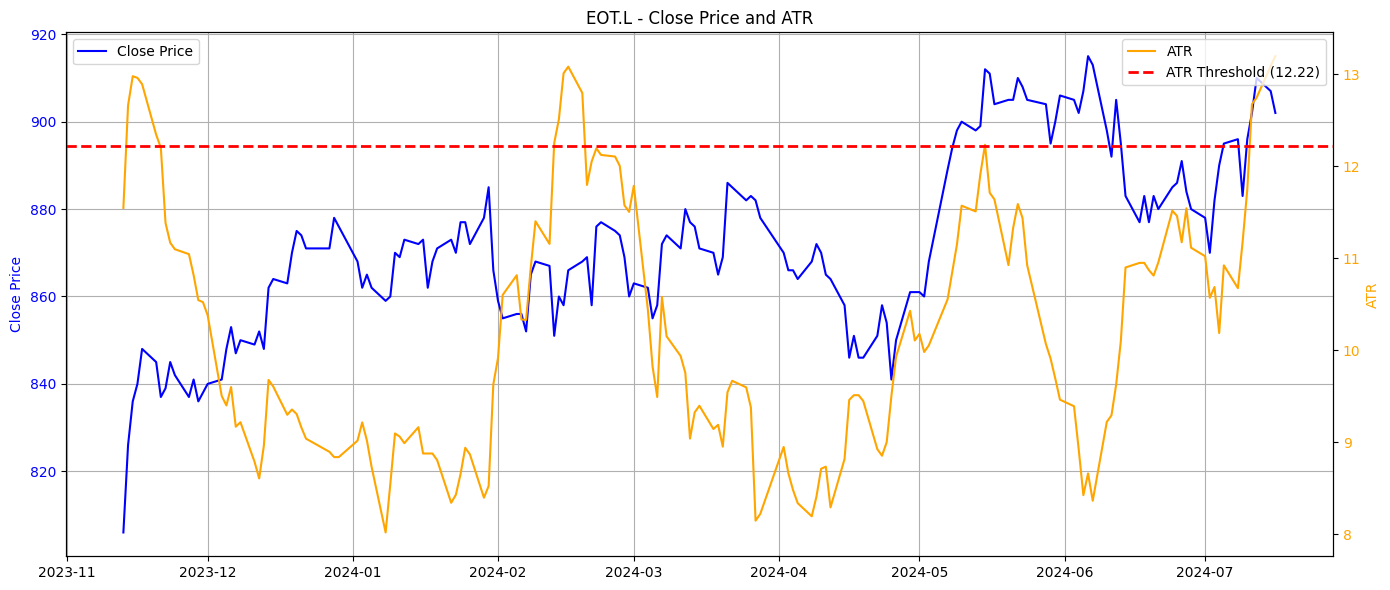

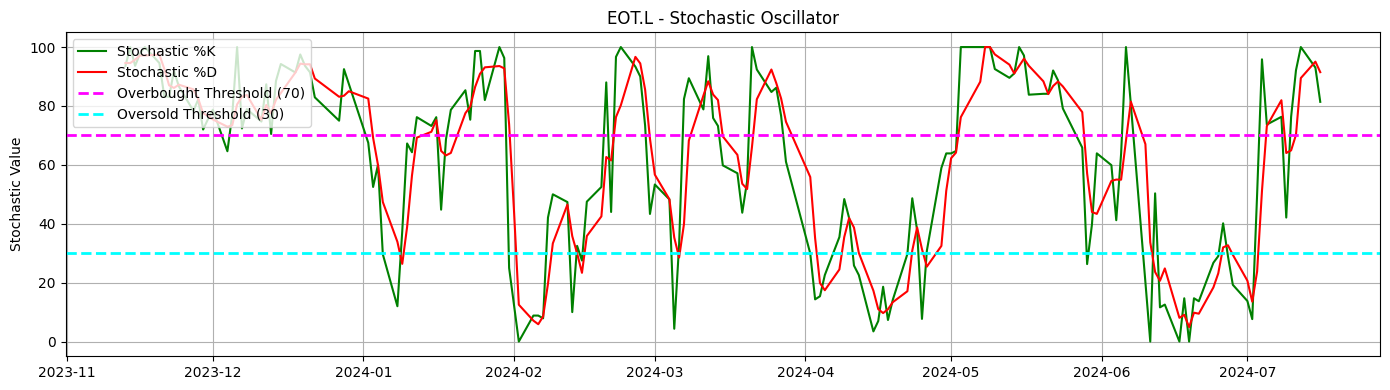

Ticker:                   EOT.L
Company:                  EUROPEAN OPPORTUNITIES TRUST PL
Sector:                   N/A
Industry:                 N/A
Market Cap:               £578,927,488
Shares Outstanding:       N/A
52-Week High:             985.79
52-Week Low:              748.0
PE Ratio (TTM):           13.711539
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


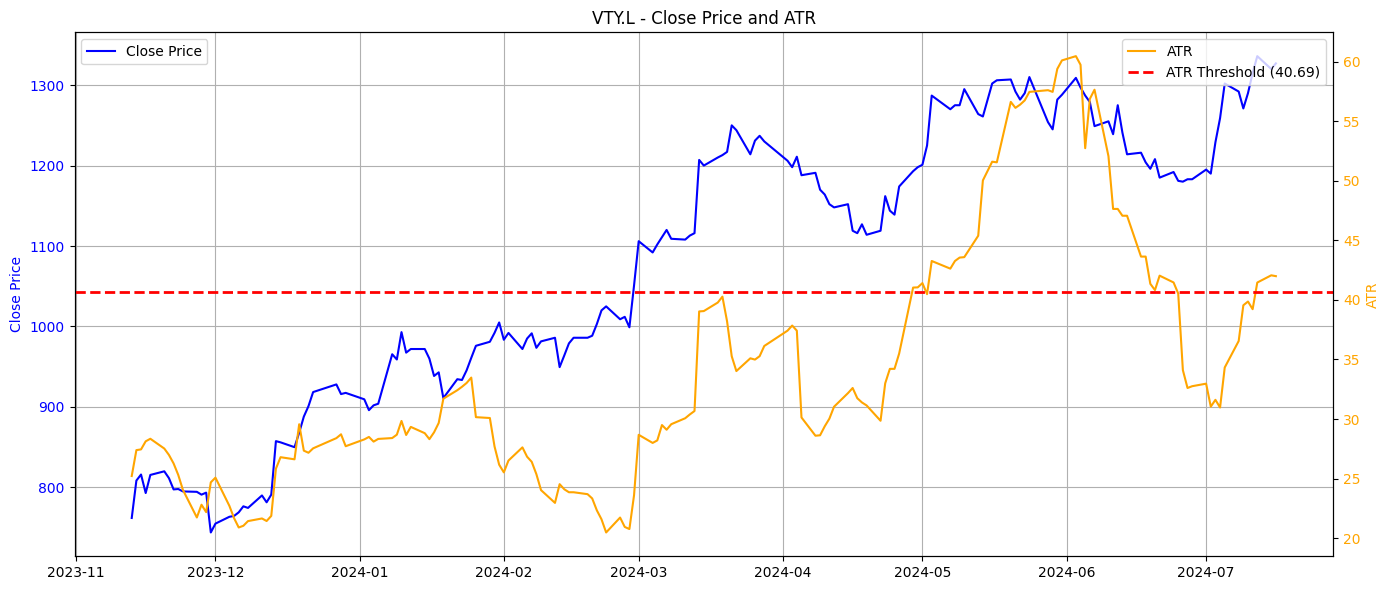

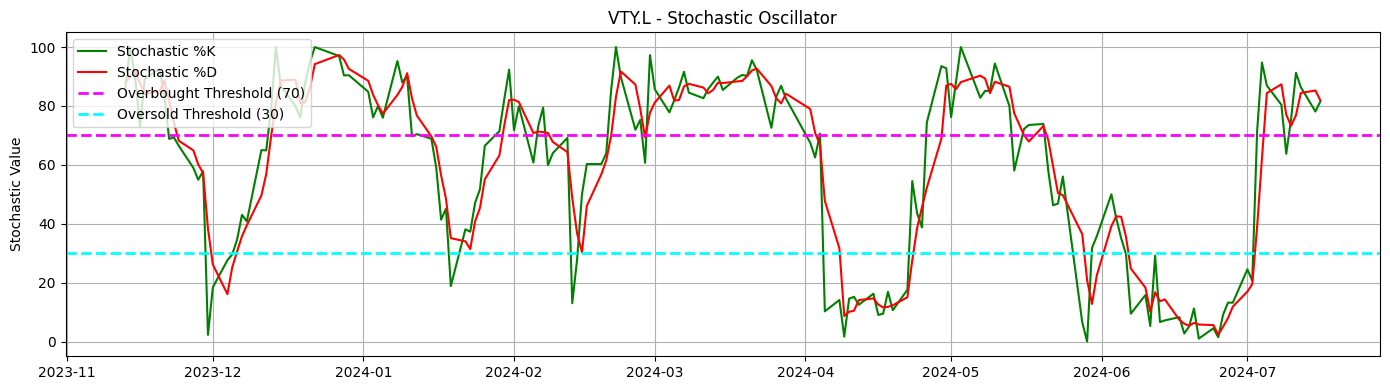

Ticker:                   VTY.L
Company:                  VISTRY GROUP PLC ORD 50P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £4,466,854,400
Shares Outstanding:       336,612,992
52-Week High:             1383.0
52-Week Low:              668.0
PE Ratio (TTM):           20.734377
EPS (TTM):                0.64
Dividend Yield:           N/A
Payout Ratio:             0.50240004
Revenue (TTM):            £3,564,199,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £223,400,000
Total Debt:               £605,400,000
Operating Cash Flow (TTM): £-72,100,000
Free Cash Flow (TTM):     £-24,162,500

Description:              Vistry Group PLC, together with its subsidiaries, provides housing solutions in the United Kingdom. It offers o single family housing model. The company was formerly known as Bovis Homes Group PLC and changed its name to Vistry Group PLC in January 2020. Vistry Group PLC was founded in 18

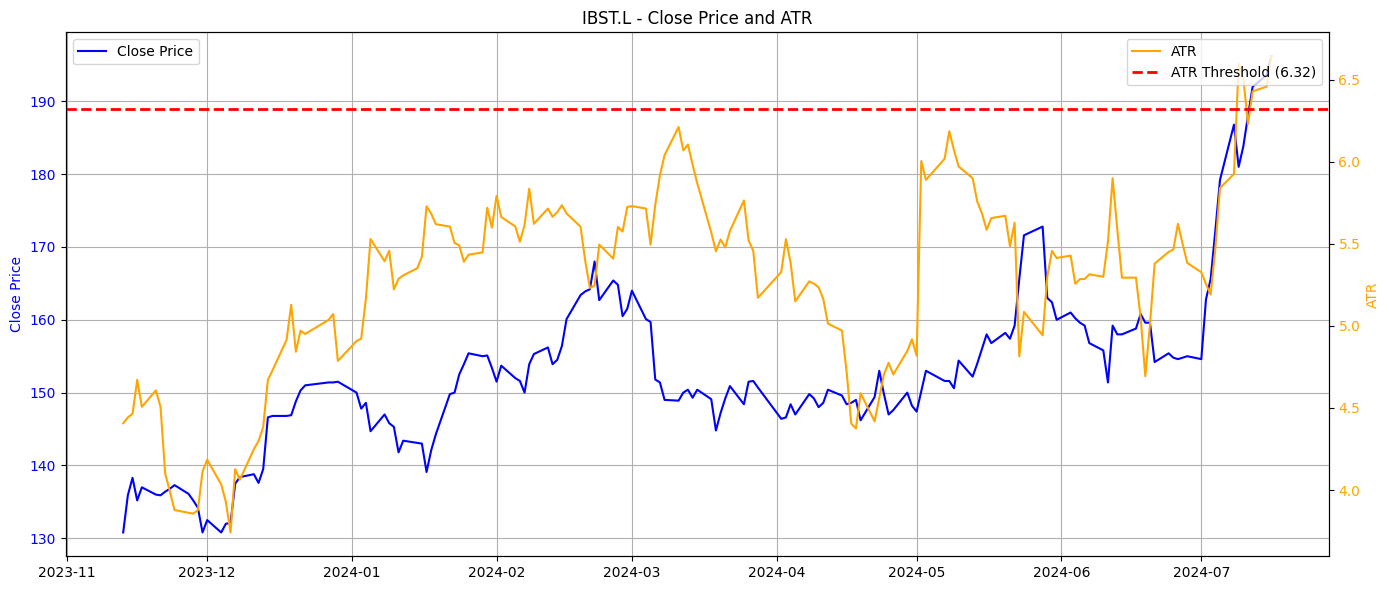

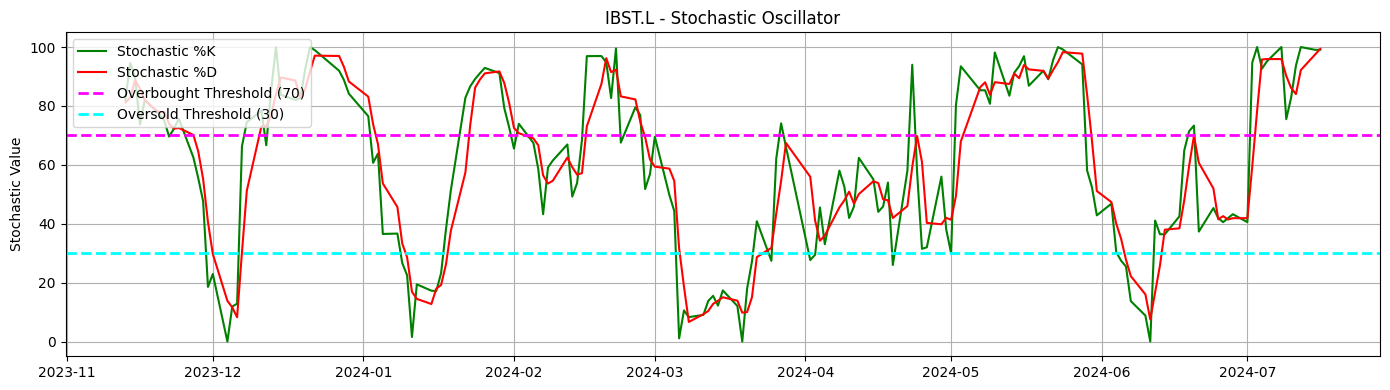

Ticker:                   IBST.L
Company:                  IBSTOCK PLC ORD 1P
Sector:                   Basic Materials
Industry:                 Building Materials
Market Cap:               £748,730,560
Shares Outstanding:       392,923,008
52-Week High:             196.6
52-Week Low:              118.0
PE Ratio (TTM):           38.110798
EPS (TTM):                0.05
Dividend Yield:           0.0374
Payout Ratio:             1.6791999
Revenue (TTM):            £405,839,008
Gross Profit (TTM):       N/A
Net Income (TTM):         £21,060,000
Total Debt:               £168,320,992
Operating Cash Flow (TTM): £58,251,000
Free Cash Flow (TTM):     £-18,240,876

Description:              Ibstock plc manufactures and sells clay and concrete building products and solutions to customers in the residential construction sector in the United Kingdom. The company offers bricks and masonry, which includes facing and engineering bricks, brick slips, special shaped bricks, walling stone, architectur

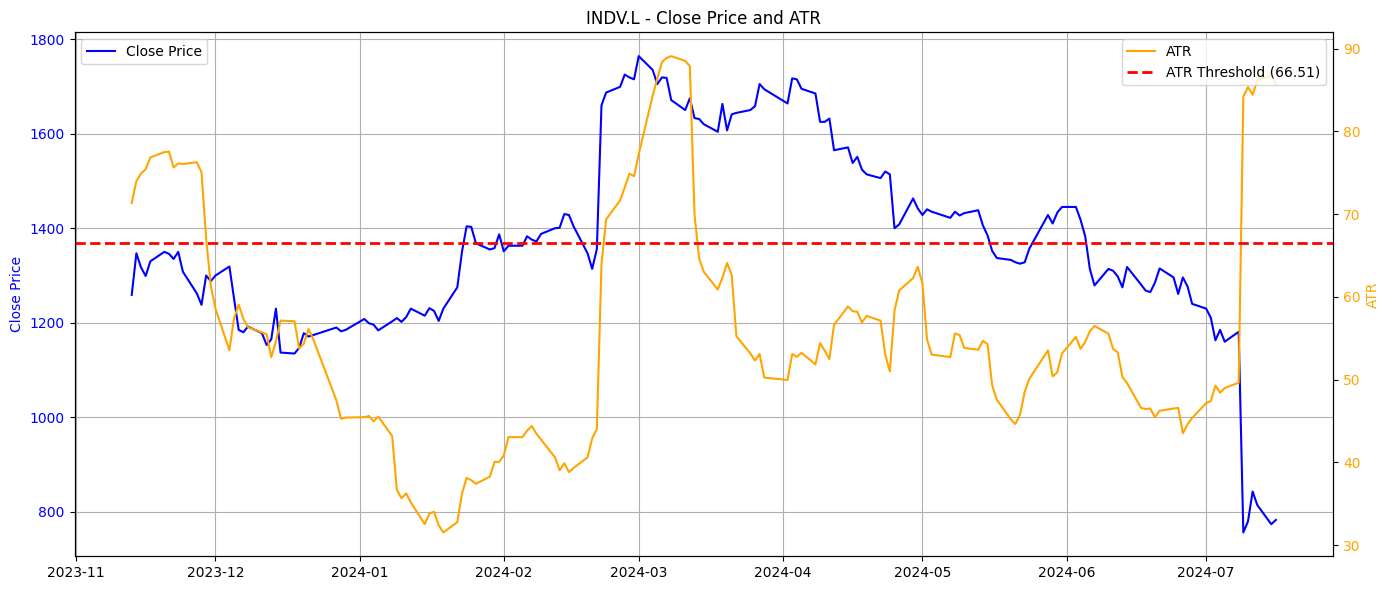

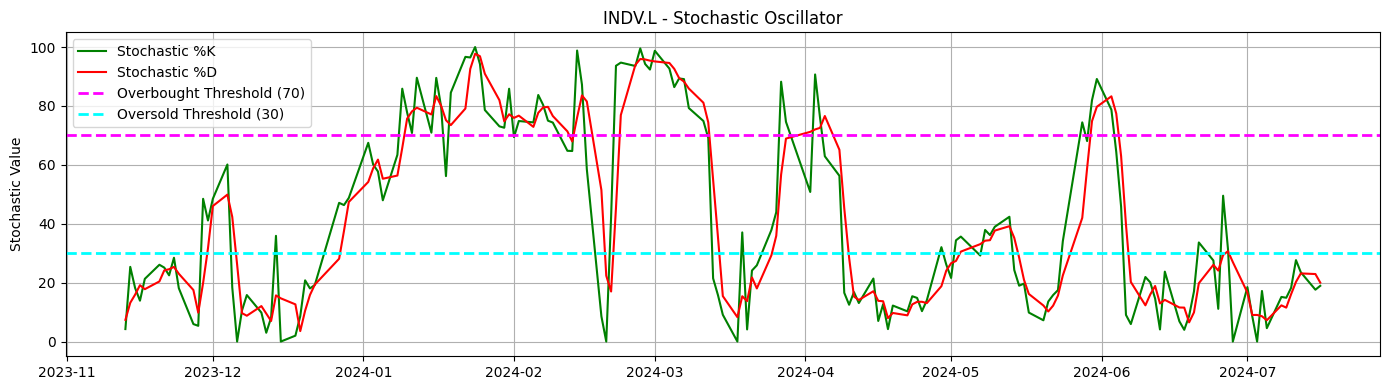

Ticker:                   INDV.L
Company:                  INDIVIOR PLC ORD USD0.50
Sector:                   Healthcare
Industry:                 Drug Manufacturers - Specialty & Generic
Market Cap:               £1,088,574,464
Shares Outstanding:       133,896,000
52-Week High:             1938.0
52-Week Low:              653.0
PE Ratio (TTM):           271.0
EPS (TTM):                0.03
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £1,124,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £5,000,000
Total Debt:               £279,000,000
Operating Cash Flow (TTM): £-334,000,000
Free Cash Flow (TTM):     £-87,375,000

Description:              Indivior PLC, together with its subsidiaries, engages in the development, manufacture, and sale of buprenorphine-based prescription drugs for the treatment of opioid dependence and co-occurring disorders in the United States, the United Kingdom, and internationally. The company develops med

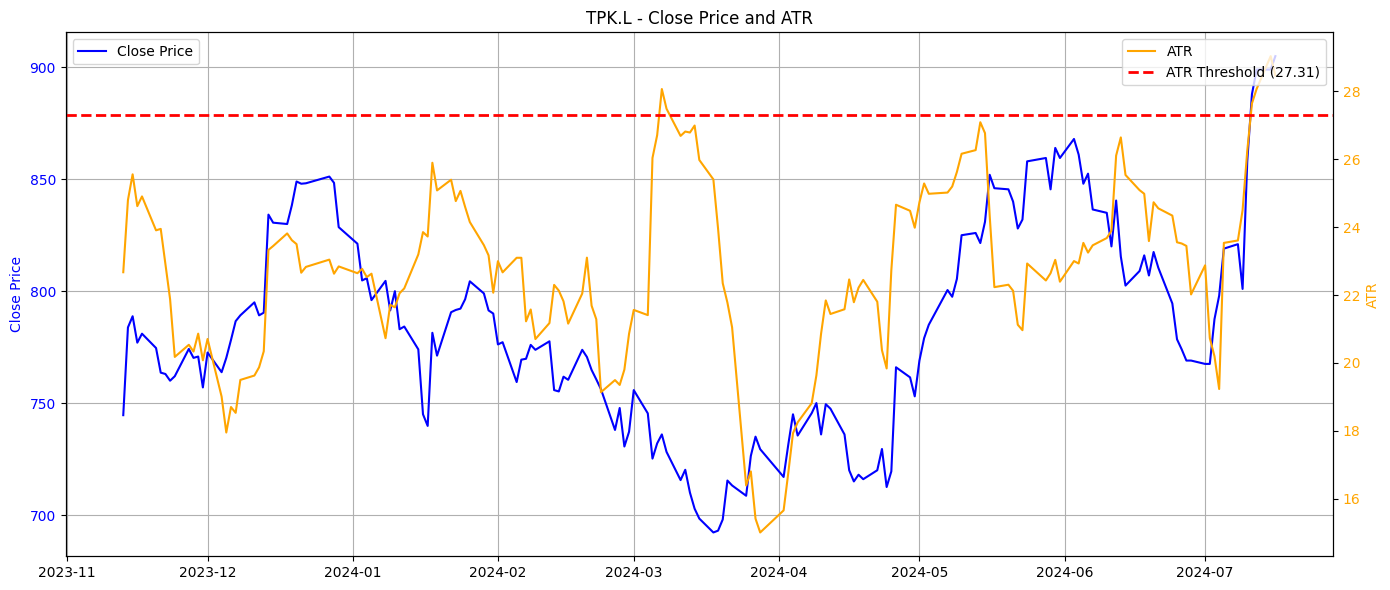

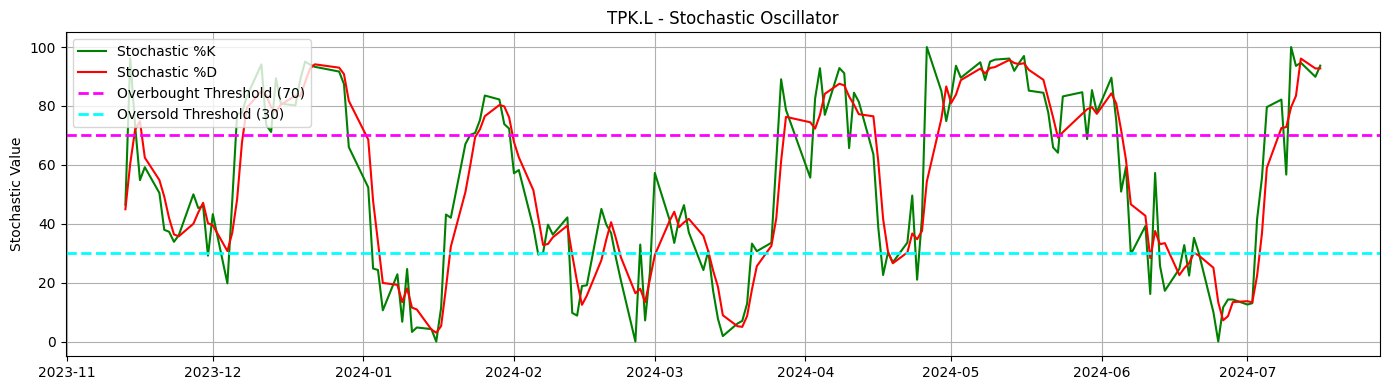

Ticker:                   TPK.L
Company:                  TRAVIS PERKINS PLC
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £1,942,899,712
Shares Outstanding:       210,840,992
52-Week High:             934.2
52-Week Low:              684.8
PE Ratio (TTM):           51.194443
EPS (TTM):                0.18
Dividend Yield:           0.0198
Payout Ratio:             2.191
Revenue (TTM):            £4,861,899,776
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,100,000
Total Debt:               £1,053,500,032
Operating Cash Flow (TTM): £217,600,000
Free Cash Flow (TTM):     £114,362,496

Description:              Travis Perkins plc engages in distribution of building material products in the United Kingdom. It operates through Merchanting and Toolstation segments. The company offers tools and building supplies. It also distributes pipeline products, as well as supplies managed services, and commercial and 

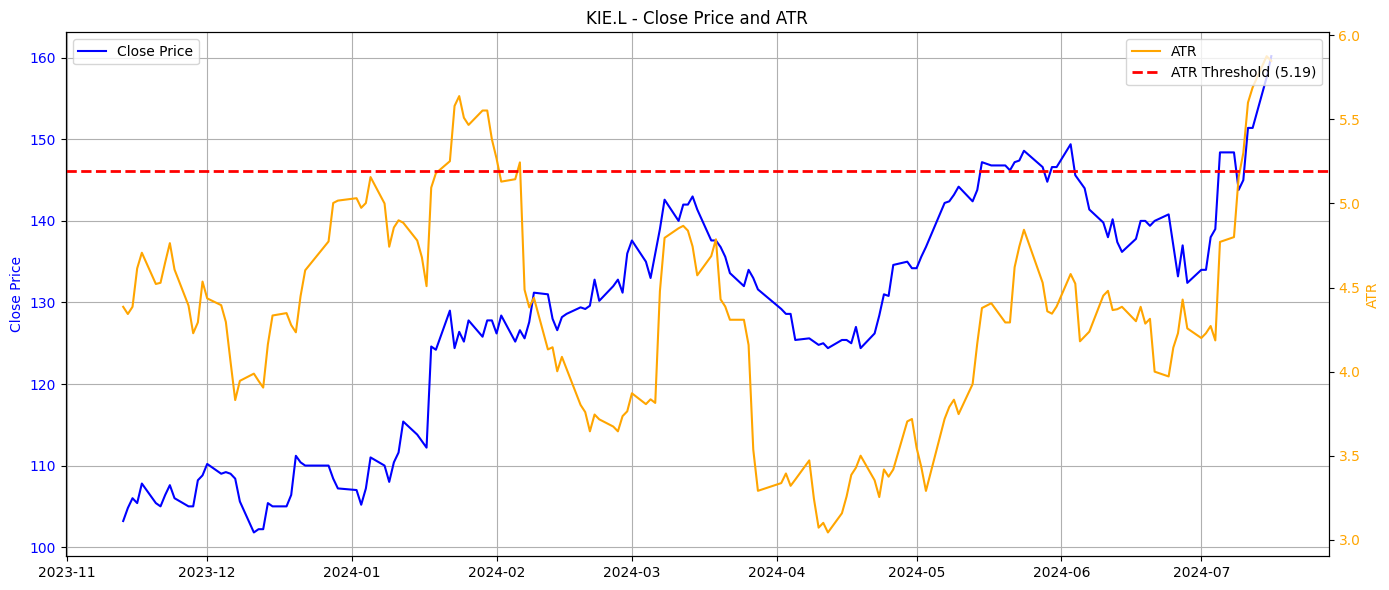

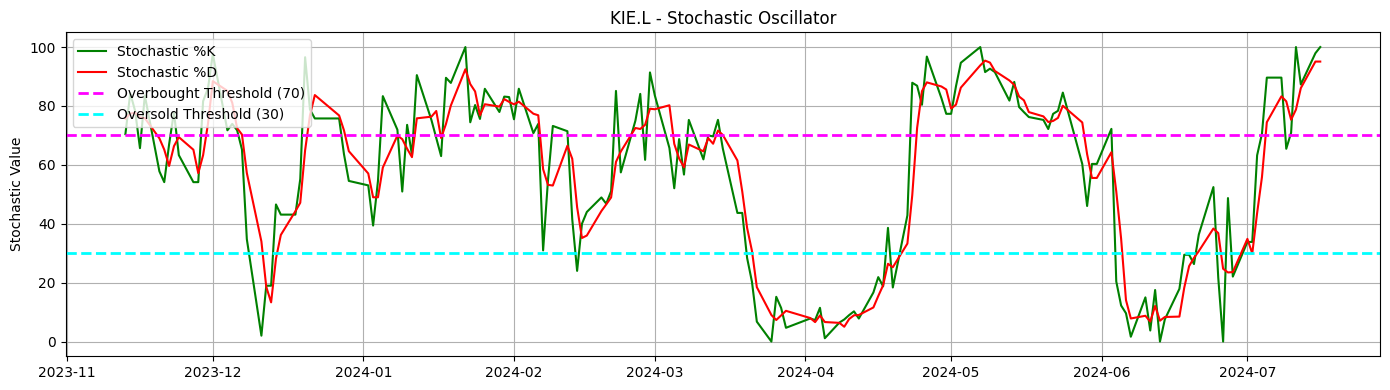

Ticker:                   KIE.L
Company:                  KIER GROUP PLC ORD 1P
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £727,031,488
Shares Outstanding:       452,134,016
52-Week High:             163.268
52-Week Low:              81.1
PE Ratio (TTM):           17.866667
EPS (TTM):                0.09
Dividend Yield:           0.021300001
Payout Ratio:             0.0
Revenue (TTM):            £3,716,999,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £40,200,000
Total Debt:               £490,400,000
Operating Cash Flow (TTM): £273,100,000
Free Cash Flow (TTM):     £253,024,992

Description:              Kier Group plc primarily engages in the construction business in the United Kingdom and internationally. The company operates through three segments: Construction, Infrastructure Services, and Property. It constructs power stations, roads, bridges, railways, tunnels, and buildings for public and p

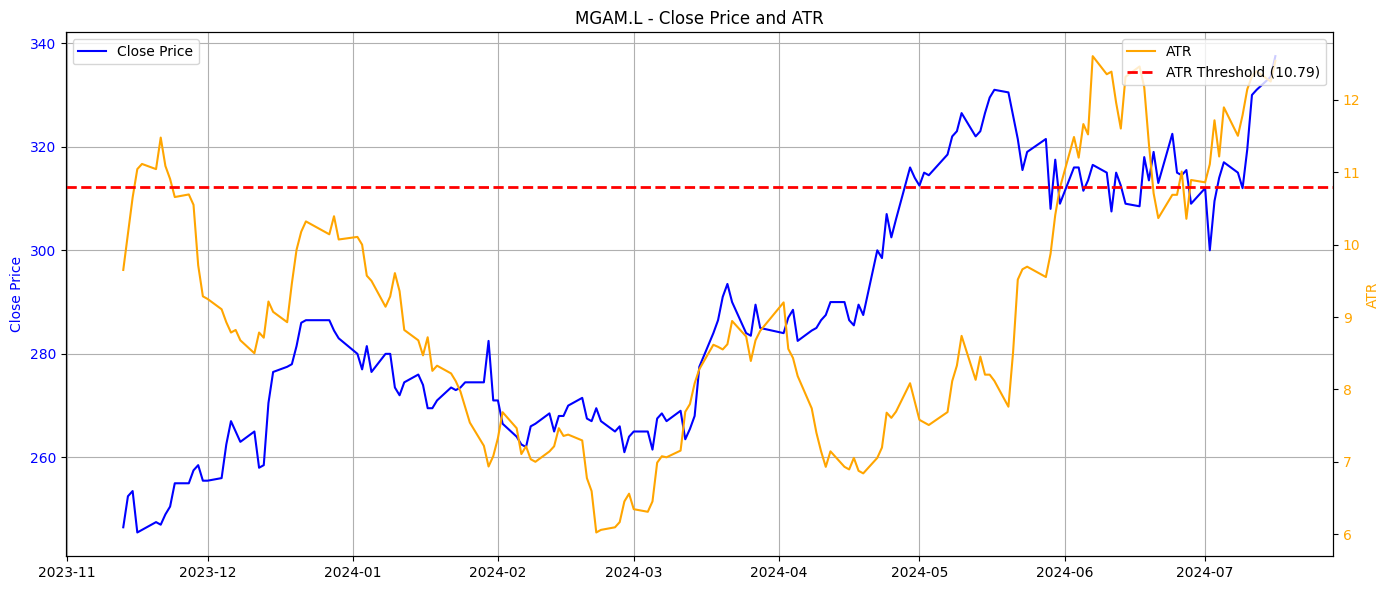

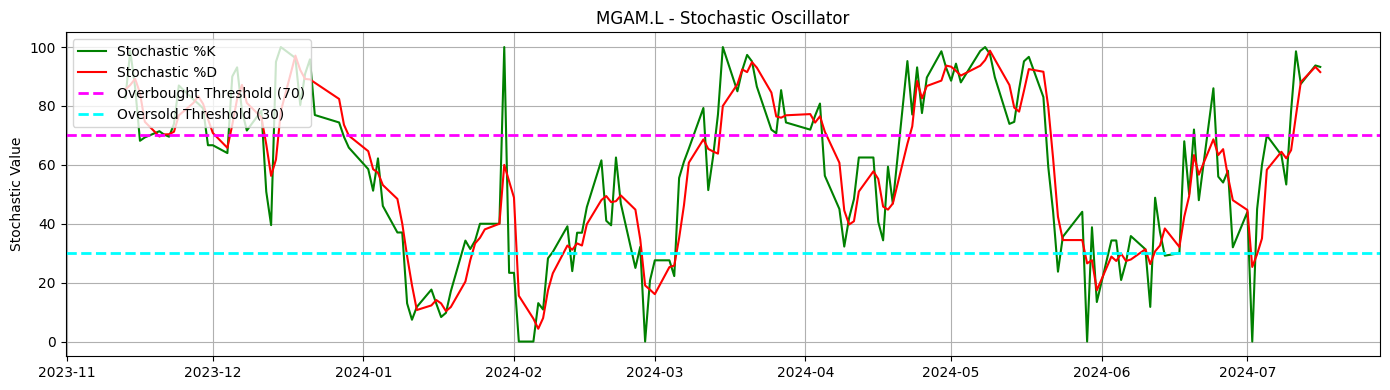

Ticker:                   MGAM.L
Company:                  MORGAN ADVANCED MATERIALS PLC O
Sector:                   Industrials
Industry:                 Specialty Industrial Machinery
Market Cap:               £943,322,944
Shares Outstanding:       284,561,984
52-Week High:             340.5
52-Week Low:              215.5
PE Ratio (TTM):           20.71875
EPS (TTM):                0.16
Dividend Yield:           0.0364
Payout Ratio:             0.73620003
Revenue (TTM):            £1,114,700,032
Gross Profit (TTM):       N/A
Net Income (TTM):         £46,600,000
Total Debt:               £356,800,000
Operating Cash Flow (TTM): £78,500,000
Free Cash Flow (TTM):     £47,675,000

Description:              Morgan Advanced Materials plc operates as a materials science and application engineering company primarily the United Kingdom. It serves customers in the industrial, transportation, petrochemical and chemical, energy, semiconductor and electronics, healthcare, and security and defens

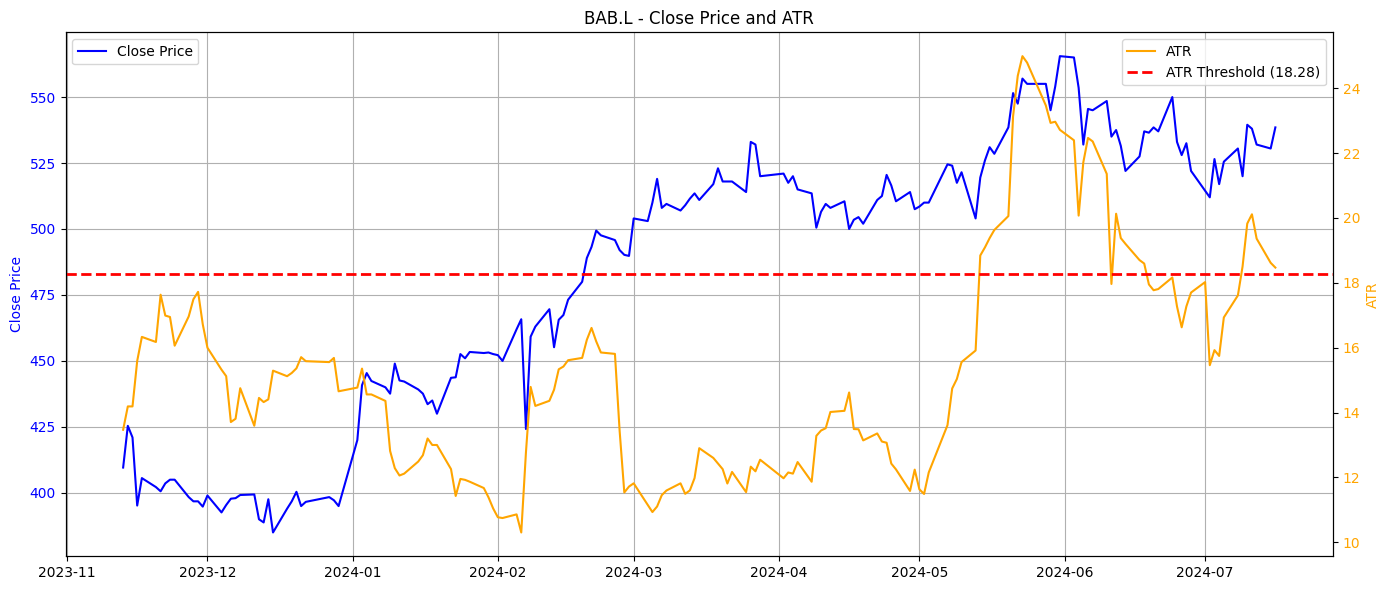

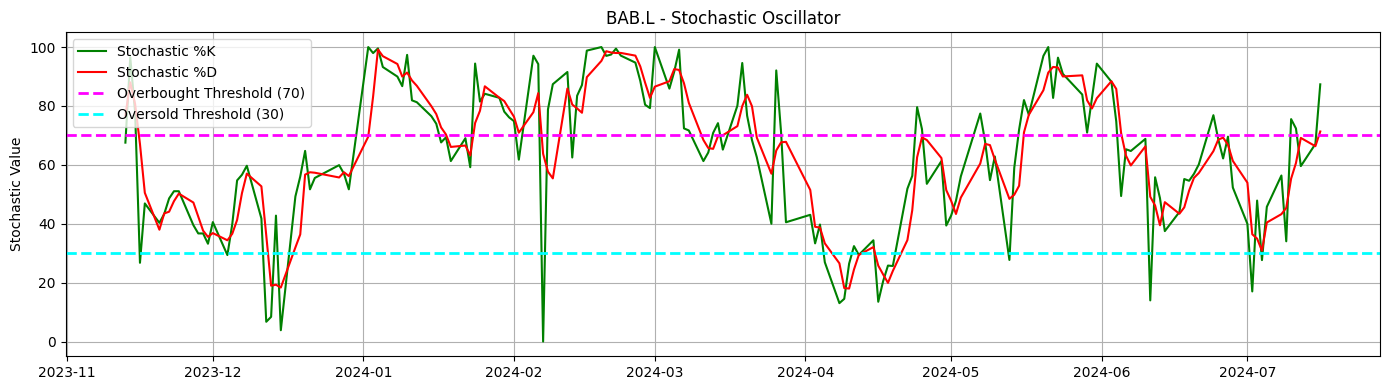

Ticker:                   BAB.L
Company:                  BABCOCK INTERNATIONAL GROUP PLC
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £2,570,960,640
Shares Outstanding:       505,596,992
52-Week High:             575.0
52-Week Low:              306.6
PE Ratio (TTM):           84.75
EPS (TTM):                0.06
Dividend Yield:           0.0066000004
Payout Ratio:             0.0
Revenue (TTM):            £4,471,600,128
Gross Profit (TTM):       N/A
Net Income (TTM):         £32,900,000
Total Debt:               £959,800,000
Operating Cash Flow (TTM): £349,200,000
Free Cash Flow (TTM):     £253,375,008

Description:              Babcock International Group PLC, together with its subsidiaries, provides value-add services for aerospace, defense, and security in the United Kingdom, rest of Europe, Africa, North America, Australasia, and internationally. The company operates through four segments: Marine, Nuclear, Lan

In [6]:
# Function to print basic financial data
def print_financial_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    def format_value(value, currency=False):
        if isinstance(value, (int, float)):
            formatted_value = f"{value:,}"
            if currency:
                formatted_value = f"£{formatted_value}"
            return formatted_value
        return value

    market_cap = format_value(info.get('marketCap', 'N/A'), currency=True)
    shares_outstanding = format_value(info.get('sharesOutstanding', 'N/A'))
    year_high = info.get('fiftyTwoWeekHigh', 'N/A')
    year_low = info.get('fiftyTwoWeekLow', 'N/A')
    pe_ratio = info.get('trailingPE', 'N/A')
    eps = info.get('trailingEps', 'N/A')
    dividend_yield = info.get('dividendYield', 'N/A')
    payout_ratio = info.get('payoutRatio', 'N/A')
    revenue = format_value(info.get('totalRevenue', 'N/A'), currency=True)
    gross_profit = format_value(info.get('grossProfits', 'N/A'), currency=True)
    net_income = format_value(info.get('netIncomeToCommon', 'N/A'), currency=True)
    total_debt = format_value(info.get('totalDebt', 'N/A'), currency=True)
    operating_cash_flow = format_value(info.get('operatingCashflow', 'N/A'), currency=True)
    free_cash_flow = format_value(info.get('freeCashflow', 'N/A'), currency=True)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    description = info.get('longBusinessSummary', 'N/A')

    print(f"{'Ticker:':<25} {ticker}")
    print(f"{'Company:':<25} {info.get('shortName', 'N/A')}")
    print(f"{'Sector:':<25} {sector}")
    print(f"{'Industry:':<25} {industry}")
    print(f"{'Market Cap:':<25} {market_cap}")
    print(f"{'Shares Outstanding:':<25} {shares_outstanding}")
    print(f"{'52-Week High:':<25} {year_high}")
    print(f"{'52-Week Low:':<25} {year_low}")
    print(f"{'PE Ratio (TTM):':<25} {pe_ratio}")
    print(f"{'EPS (TTM):':<25} {eps}")
    print(f"{'Dividend Yield:':<25} {dividend_yield}")
    print(f"{'Payout Ratio:':<25} {payout_ratio}")
    print(f"{'Revenue (TTM):':<25} {revenue}")
    print(f"{'Gross Profit (TTM):':<25} {gross_profit}")
    print(f"{'Net Income (TTM):':<25} {net_income}")
    print(f"{'Total Debt:':<25} {total_debt}")
    print(f"{'Operating Cash Flow (TTM):':<25} {operating_cash_flow}")
    print(f"{'Free Cash Flow (TTM):':<25} {free_cash_flow}")
    print(f"\n{'Description:':<25} {description}")  # Print the full description
    print("-" * 50)


def plot_combined_indicators(data, symbol, atr_threshold, stochastic_overbought, stochastic_oversold):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot Close Price
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'{symbol} - Close Price and ATR')
    ax1.grid(True)

    # Create a secondary y-axis for ATR
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['ATR'], label='ATR', color='orange')
    atr_threshold_value = atr_threshold * data['ATR'].mean()
    ax2.axhline(y=atr_threshold_value, color='red', linestyle='--', linewidth=2, label=f'ATR Threshold ({atr_threshold_value:.2f})')
    ax2.set_ylabel('ATR', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Plot Stochastic Oscillator on a separate subplot
    fig, ax3 = plt.subplots(figsize=(14, 4))
    ax3.plot(data.index, data['Stochastic %K'], label='Stochastic %K', color='green')
    ax3.plot(data.index, data['Stochastic %D'], label='Stochastic %D', color='red')
    ax3.axhline(y=stochastic_overbought, color='magenta', linestyle='--', linewidth=2, label='Overbought Threshold (70)')
    ax3.axhline(y=stochastic_oversold, color='cyan', linestyle='--', linewidth=2, label='Oversold Threshold (30)')
    ax3.set_title(f'{symbol} - Stochastic Oscillator')
    ax3.set_ylabel('Stochastic Value')
    ax3.grid(True)
    ax3.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Print the introductory text
print("The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.\n")

# Iterate through all tickers to plot graphs and print financial data
for index, row in results_df.iterrows():
    symbol = row["Symbol"]
    stock_data = next(item for item in results if item["Symbol"] == symbol)["Data"]
    plot_combined_indicators(stock_data, symbol, atr_threshold, stochastic_overbought, stochastic_oversold)
    print_financial_data(symbol)
